# Enhancing Profitability with Prudent Risk Management for a Conservative Bank

## Business Description

**Understanding Credit Scores**

A credit score is a statistical analysis conducted by banks and financial institutions to assess the creditworthiness of borrowers. It plays a crucial role in the lending decision process, helping financial entities to measure the risk associated with extending loans.

**Key Factors Impacting Credit Scores**

Several factors influence the computation of a credit score, which serves as a numerical representation of an individual's credit history. These factors include the borrower's annual income, their home ownership status, the amount of money and the interest rate charged for example. When combined, these elements make up a credit score, a tool that banks employ to make informed lending decisions.

## Business Problem

**Business Challenge: Developing a Risk Model for a Conservative Bank**

Credit Score Project is dedicated to the creation of an in-house risk model for our conservative bank, enabling informed lending decisions. Our primary aim remains the optimization of profitability, while emphasizing the importance of a cautious approach. To align with the bank's philosophy of minimizing risk exposure, we're committed to employing a well-informed strategy in customer selection.

We will take into consideration the following key financial parameters:

- A profit of $100 is expected from each good customer;
- On the other hand, a loss of $500 is expected from each bad customer.

## 0. Imports

### 0.1. Libraries

In [1]:
### Data manipulation 
import pandas                   as pd
import numpy                    as np

### Data visualization
import seaborn                  as sns
import matplotlib               as mpl
import matplotlib.pyplot        as plt
import matplotlib.dates         as mdates

### Machine learning 

import sklearn
import lightgbm
import catboost

from sklearn.model_selection    import train_test_split, RandomizedSearchCV
from sklearn.metrics            import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing      import OrdinalEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.ensemble           import RandomForestClassifier
from sklearn.utils.multiclass   import unique_labels
from sklearn.impute             import KNNImputer

from lightgbm                   import LGBMClassifier
from catboost                   import CatBoostClassifier

### Other libraries

import datetime 
import inflection
import warnings
import lxml

### 0.2. Settings

In [2]:
### Ignoring warnings
warnings.filterwarnings('ignore')

### Pandas Settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

### Visualization Settings
mpl.style.use('ggplot')

mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['figure.titlesize']    = 25
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['font.size']           = 12
mpl.rcParams['axes.grid']           = True
mpl.rcParams['figure.dpi']          = 150

sns.set_palette('YlOrBr_r')

### 0.3. Functions

In [3]:
##### Functions

def df_shape(df):
    """
    Summary: The function prints the number of rows and columns of a given DataFrame.

    Args:
        df: the DataFrame we want to know more about.
    
    Returns: a text indicating the number of rows and columns of the DataFrame.
    """

    print('Number of rows: {:,}'.format(df.shape[0]))
    print('Number of columns: {:,}'.format(df.shape[1]))

    return None

def set_image(title, xlabel, ylabel, rotation=0):
    """
    Summary: This function sets the image configuration.

    Args:
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
        rotation: the rotation of the labels. default as 0.

    Returns: None
    """

    plt.title(title)
    plt.xlabel(xlabel, color='black')
    plt.ylabel(ylabel, color='black')
    plt.xticks(rotation=rotation)
    plt.tick_params(left=False, bottom=False);

    return None


### 0.4. Loading data

In [4]:
# Importing the dataset as a Raw DataFrame
df_raw = pd.read_csv('../data/raw/credit_risk_dataset.csv')

# Copying the dataset to work with `df`
df = df_raw.copy()

## 1. Data description

In [5]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.000,PERSONAL,D,35000,16.020,1,0.590,Y,3
1,21,9600,OWN,5.000,EDUCATION,B,1000,11.140,0,0.100,N,2
2,25,9600,MORTGAGE,1.000,MEDICAL,C,5500,12.870,1,0.570,N,3
3,23,65500,RENT,4.000,MEDICAL,C,35000,15.230,1,0.530,N,2
4,24,54400,RENT,8.000,MEDICAL,C,35000,14.270,1,0.550,Y,4


### 1.1. Data Dimensions

In [6]:
df_shape(df)

Number of rows: 32,581
Number of columns: 12


### 1.2. Columns

In [7]:
df.columns.to_list()

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

| Feature Name | Description |
|---|---|
| `person_age` | Age of the person |
| `person_income` | Annual Income of the individual |
| `person_home_ownership` | Home ownership status, like mortgage, rent, or own |
| `person_emp_length` | Employment length in years |
| `loan_intent` | The intention of the loan |
| `loan_grade` | Grade for the person |
| `loan_amnt` | Amount of money requested |
| `loan_int_rate` | Interest rate charged |
| `loan_status` | Loan status (0 for non default and 1 for default) |
| `loan_percent_income` | Percentage of the loan amount for the income  |
| `cb_person_default_on_file` | If the person has historical default |
| `cb_preson_cred_hist_length` | Credit history length in years |

### 1.3. Data Types

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


### 1.4. Describing Data

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.000,27.735,6.348,20.000,23.000,26.000,30.000,144.000
person_income,32581.000,66074.848,61983.119,4000.000,38500.000,55000.000,79200.000,6000000.000
person_emp_length,31686.000,4.790,4.143,0.000,2.000,4.000,7.000,123.000
loan_amnt,32581.000,9589.371,6322.087,500.000,5000.000,8000.000,12200.000,35000.000
loan_int_rate,29465.000,11.012,3.240,5.420,7.900,10.990,13.470,23.220
loan_status,32581.000,0.218,0.413,0.000,0.000,0.000,0.000,1.000
loan_percent_income,32581.000,0.170,0.107,0.000,0.090,0.150,0.230,0.830
cb_person_cred_hist_length,32581.000,5.804,4.055,2.000,3.000,4.000,8.000,30.000


### 1.5. Checking NaN and Duplicates

In [11]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [12]:
duplicates = df.duplicated()
df[duplicates]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.000,VENTURE,B,6000,9.990,0,0.140,N,4
15989,23,90000,MORTGAGE,7.000,EDUCATION,B,8000,10.360,0,0.090,N,3
15995,24,48000,MORTGAGE,4.000,MEDICAL,A,4000,5.420,0,0.080,N,4
16025,24,10000,RENT,8.000,PERSONAL,A,3000,7.900,1,0.300,N,3
16028,23,100000,MORTGAGE,7.000,EDUCATION,A,15000,7.880,0,0.150,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.000,HOMEIMPROVEMENT,A,2500,5.420,0,0.060,N,12
32047,36,250000,RENT,2.000,DEBTCONSOLIDATION,A,20000,7.880,0,0.080,N,17
32172,49,120000,MORTGAGE,12.000,MEDICAL,B,12000,10.990,0,0.100,N,12
32259,39,40000,OWN,4.000,VENTURE,B,1000,10.370,0,0.030,N,16


## 2. Data Exploration and Preprocessing

### 2.1. Dropping duplicates

In [13]:
print('Percentage of duplicated rows in dataset: {:.2f}%'.format(df.duplicated().sum()/len(df)*100))

Percentage of duplicated rows in dataset: 0.51%


Considering it is highly unlikely that two individuals have the exact same information in the dataset and that the duplicates are only 0.51% of it, we can drop the duplicated rows without losing important information.

In [14]:
df.drop_duplicates(inplace=True)

print('The dataset had {:,} rows, without the duplicates it has {:,}.'.format(df_raw.shape[0], df.shape[0]))

The dataset had 32,581 rows, without the duplicates it has 32,416.


### 2.2. Exploring unusual values

In [15]:
df.loc[df['person_age'] > 100, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.000,VENTURE,C,4800,13.570,0,0.020,N,3
183,144,200000,MORTGAGE,4.000,EDUCATION,B,6000,11.860,0,0.030,N,2
575,123,80004,RENT,2.000,EDUCATION,B,20400,10.250,0,0.250,N,3
747,123,78000,RENT,7.000,VENTURE,B,20000,NaN,0,0.260,N,4
32297,144,6000000,MORTGAGE,12.000,PERSONAL,C,5000,12.730,0,0.000,N,25


In [16]:
df.loc[df['person_emp_length'] > 70, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.000,PERSONAL,D,35000,16.020,1,0.590,Y,3
210,21,192000,MORTGAGE,123.000,VENTURE,A,20000,6.540,0,0.100,N,4


In [17]:
df.loc[(df['person_age'] - 15) < df['person_emp_length'], :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.000,PERSONAL,D,35000,16.020,1,0.590,Y,3
210,21,192000,MORTGAGE,123.000,VENTURE,A,20000,6.540,0,0.100,N,4


In [18]:
# Selecting only rows with age less than or equal to 100
df = df.loc[df['person_age'] <= 100, :]

# As we have missing values in column 'person_emp_length', we need to keep these values when filtering
df = df.loc[(df['person_emp_length'] <= 70) | (df['person_emp_length'].isna()), :]

## 3. Exploratory Data Analysis

### 3.1. How is the target variable distributed through the dataset?

In [19]:
print('The Non-Default Loan Status corresponds to {:.2f}% of the dataset.'.format((df['loan_status'].value_counts(normalize=True)[0])*100))
print('The Default Loan Status corresponds to {:.2f}% of the dataset.'.format((df['loan_status'].value_counts(normalize=True)[1])*100))

The Non-Default Loan Status corresponds to 78.13% of the dataset.
The Default Loan Status corresponds to 21.87% of the dataset.


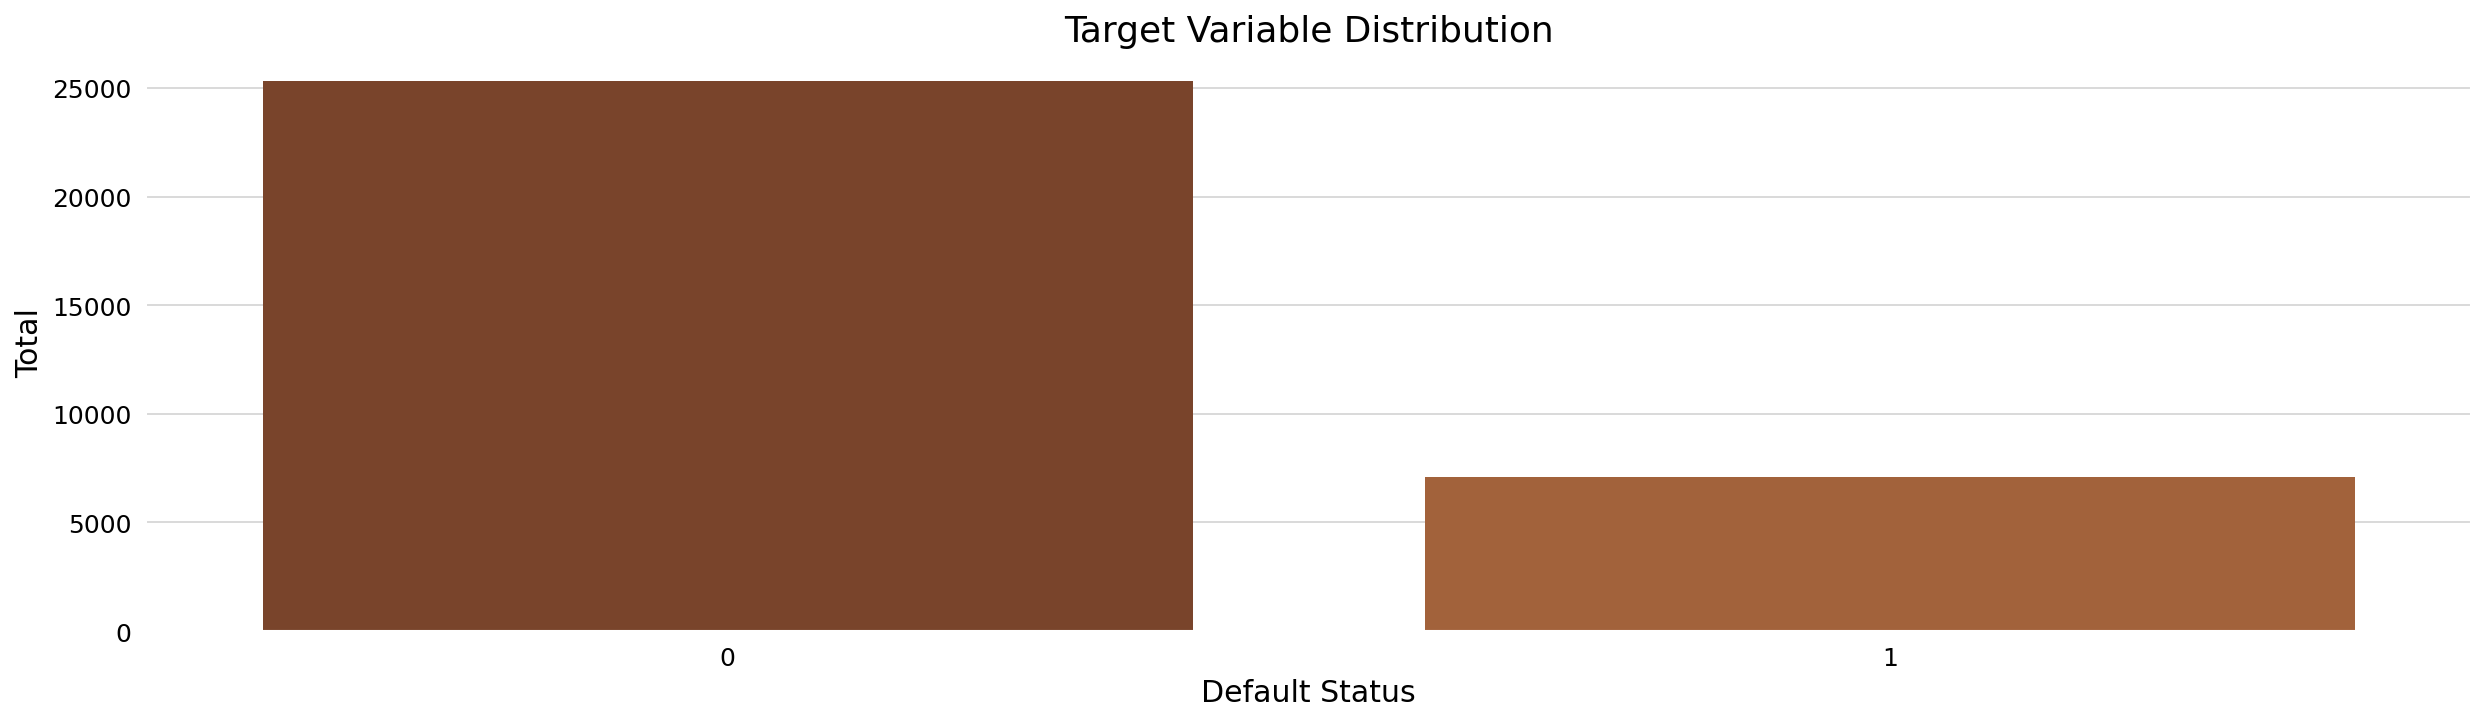

In [20]:
sns.countplot(df, x='loan_status', saturation=0.5)

set_image('Target Variable Distribution', 'Default Status', 'Total')

### 3.2. How is the distribution of numerical variables?

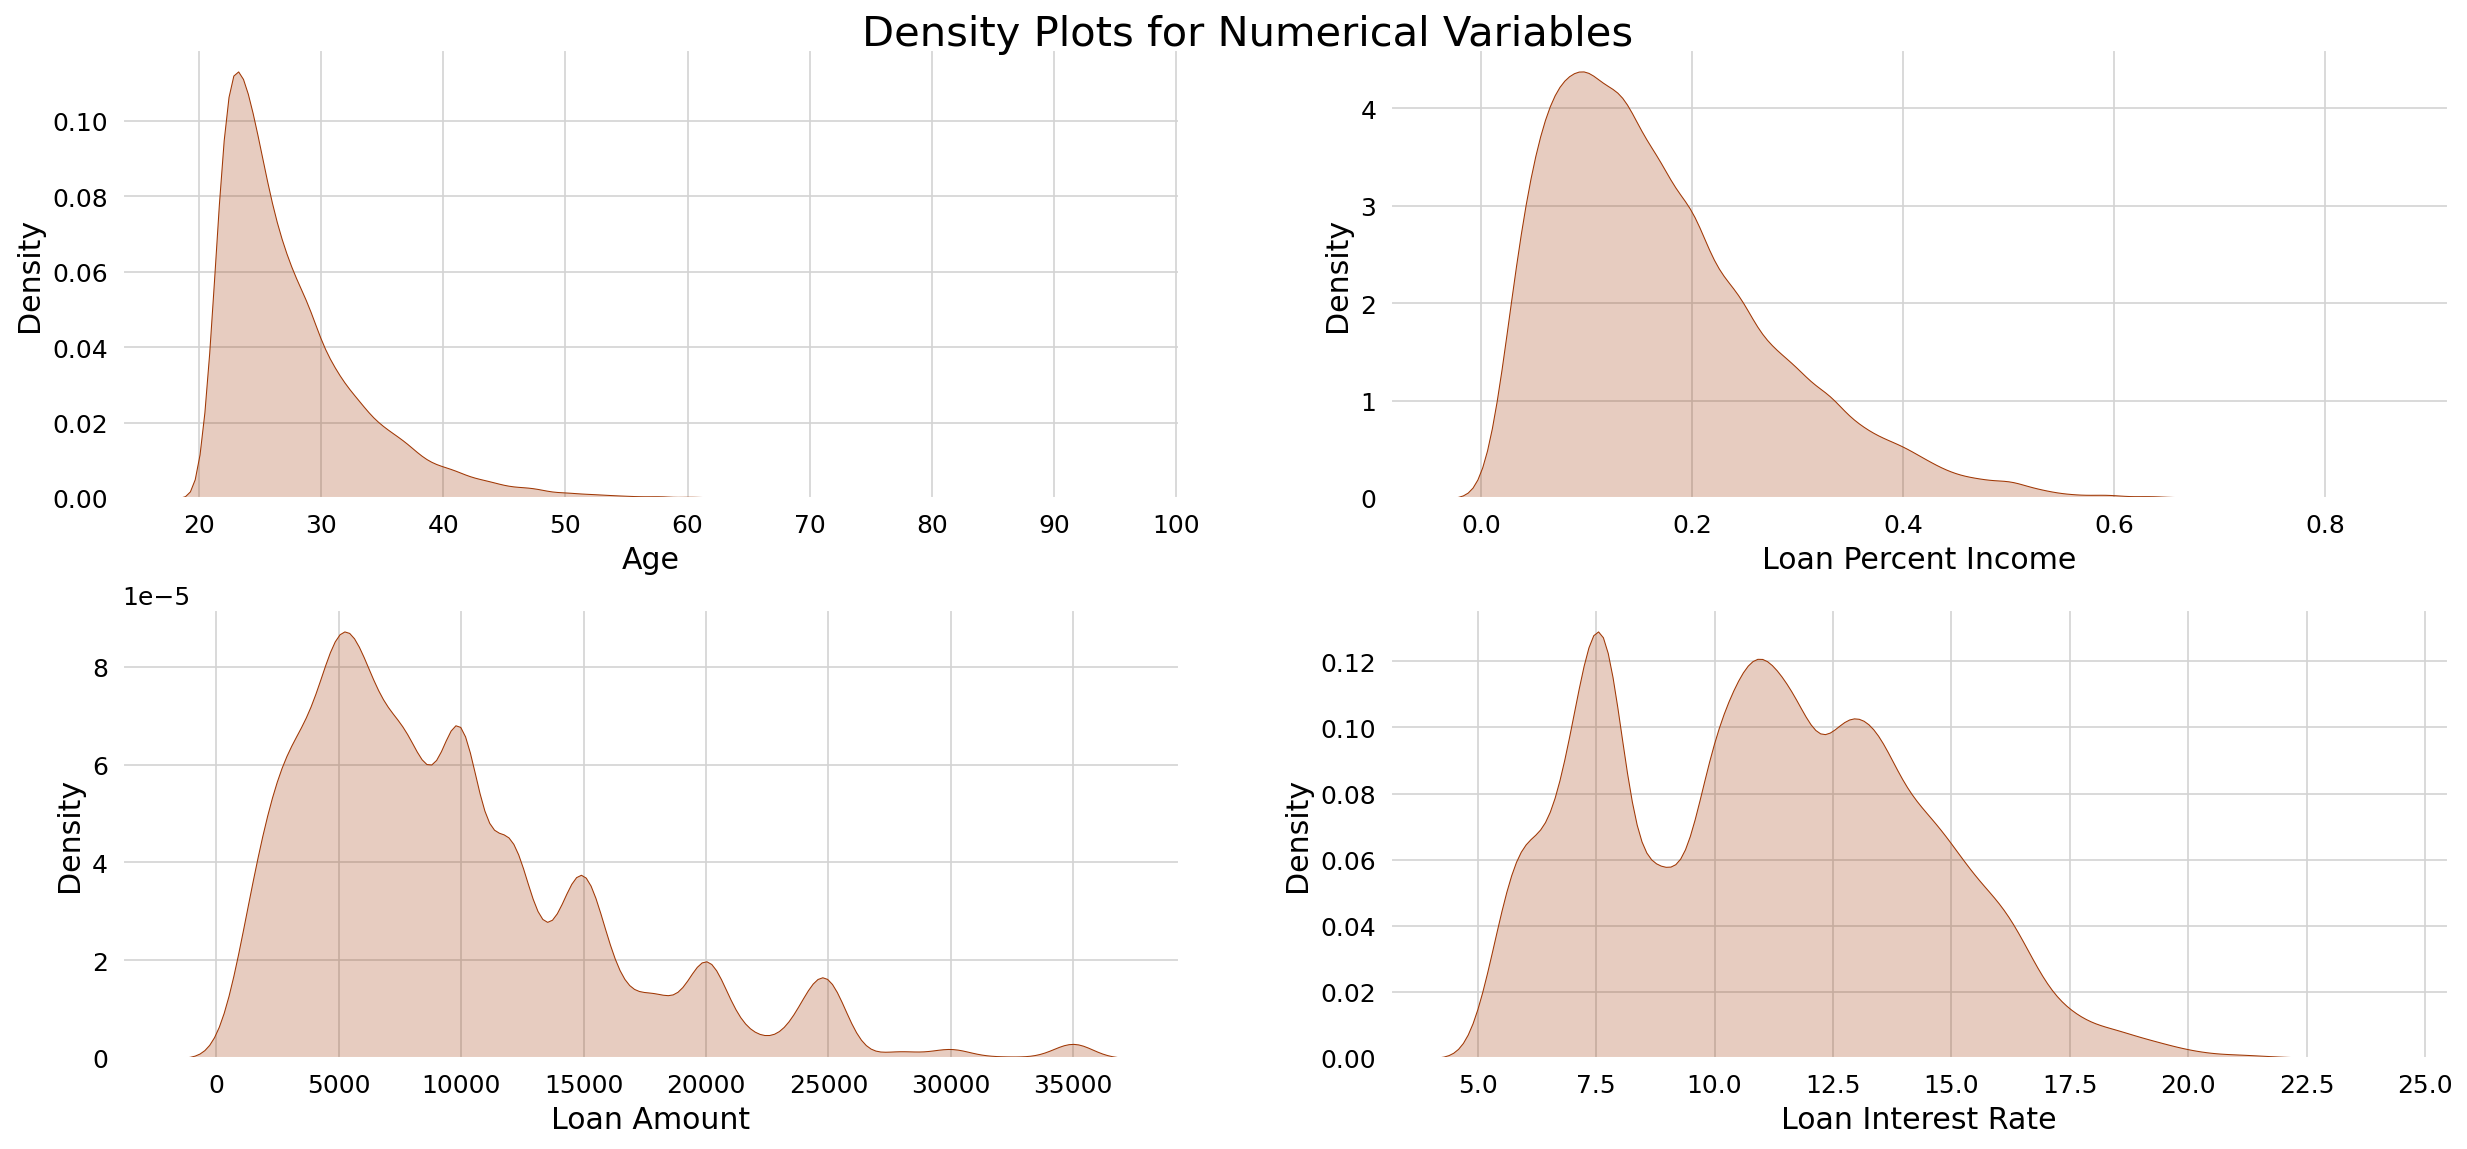

In [21]:
# Density plots for numerical variables: age, income, loan amount, and loan interest rate

# Setting subplots and figsize
fig, ax = plt.subplots(2, 2, figsize=(20, 8))

# Subplots
plt.subplot(2, 2, 1)
sns.kdeplot(df['person_age'], shade=True)
set_image(None, 'Age', 'Density')

plt.subplot(2, 2, 2)
sns.kdeplot(df['loan_percent_income'], shade=True)
set_image(None, 'Loan Percent Income', 'Density')

plt.subplot(2, 2, 3)
sns.kdeplot(df['loan_amnt'], shade=True)
set_image(None, 'Loan Amount', 'Density')

plt.subplot(2, 2, 4)
sns.kdeplot(df['loan_int_rate'], shade=True)
set_image(None, 'Loan Interest Rate', 'Density')

# Setting main plot title
fig.suptitle('Density Plots for Numerical Variables', fontsize=20)

# Adjusting spacing
fig.subplots_adjust(top=0.95, hspace=0.25)

### 3.3. Does the Age of the Person might have an impact on the Loan Status?

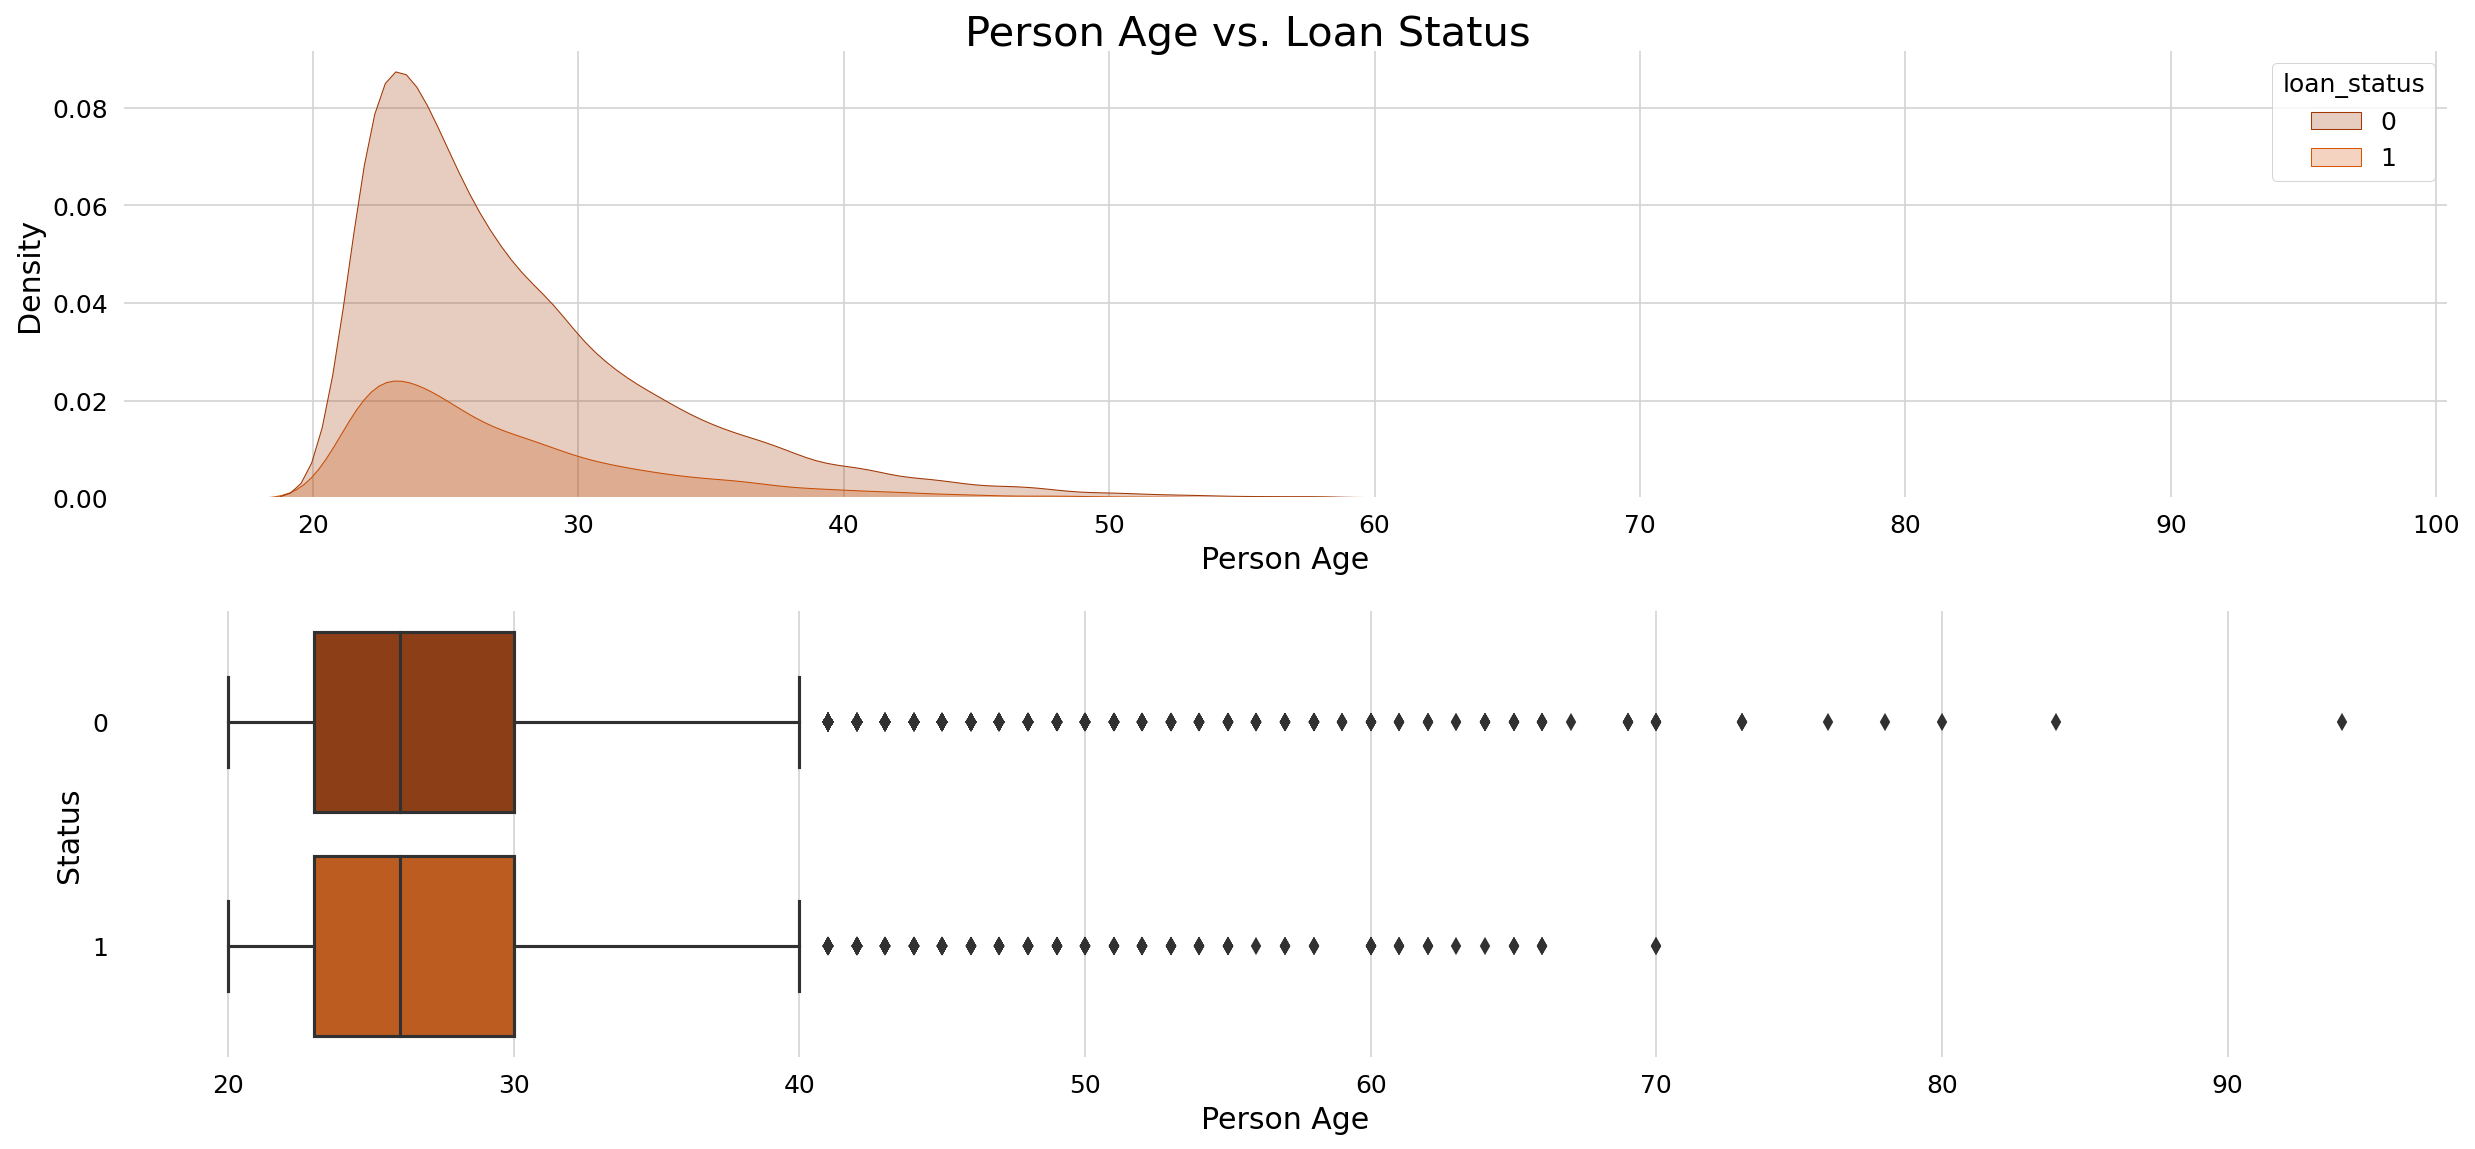

In [22]:
# Creating the figure
fig, ax = plt.subplots(2, 1, figsize=(20, 8))

# Density plot
plt.subplot(2, 1, 1)
sns.kdeplot(data=df, x='person_age', shade=True, hue='loan_status')
set_image(None, 'Person Age', 'Density')

# Boxplot
plt.subplot(2, 1, 2)
sns.boxplot(data=df, x = "person_age", y = "loan_status", orient='h')
set_image(None, 'Person Age', 'Status')

# Setting main plot title
fig.suptitle('Person Age vs. Loan Status', fontsize=20)

# Adjusting spacing
fig.subplots_adjust(top=0.95, hspace=0.25)

### 3.4. Does the Income of the Person might have an impact on the Loan Status?

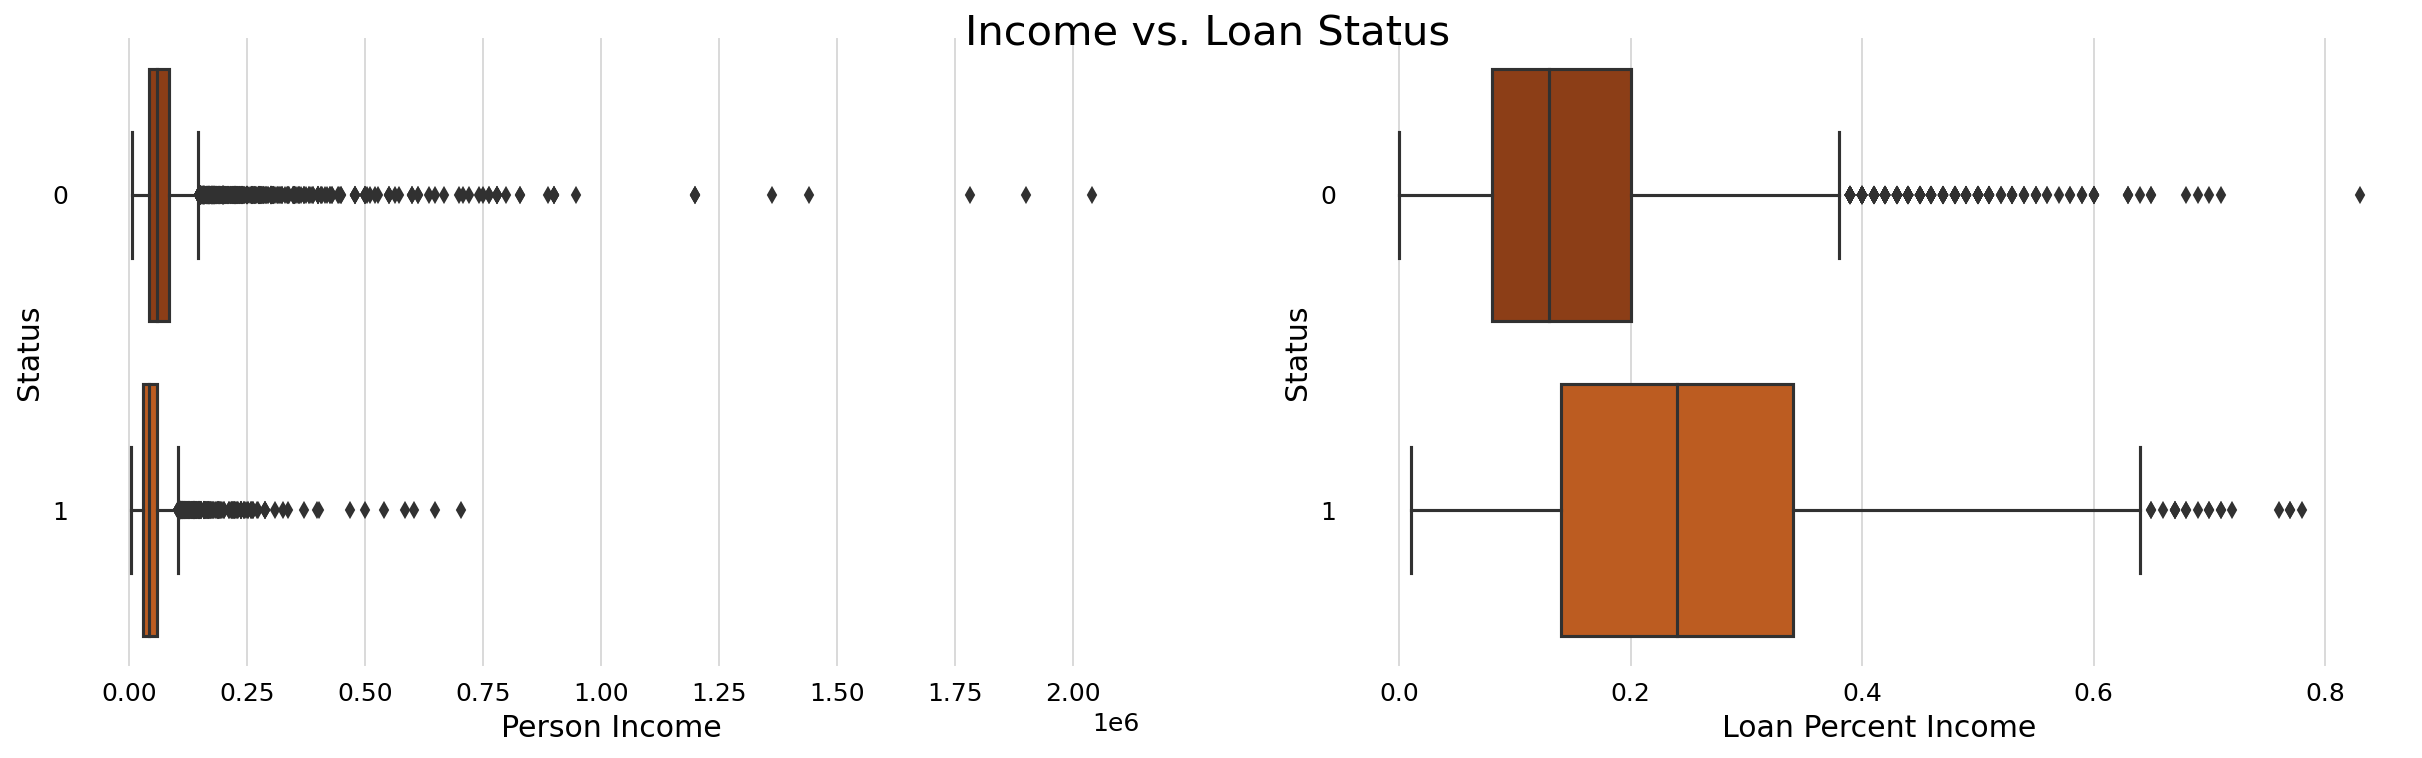

In [23]:
# Creating the figure
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Boxplot 1
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x = "person_income", y = "loan_status", orient='h')
set_image(None, 'Person Income', 'Status')

# Boxplot 2
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x = "loan_percent_income", y = "loan_status", orient='h')
set_image(None, 'Loan Percent Income', 'Status')

# Setting main plot title
fig.suptitle('Income vs. Loan Status', fontsize=20)

# Adjusting spacing
fig.subplots_adjust(top=0.95)

### 3.5. What are the main reasons for Loan Intent?

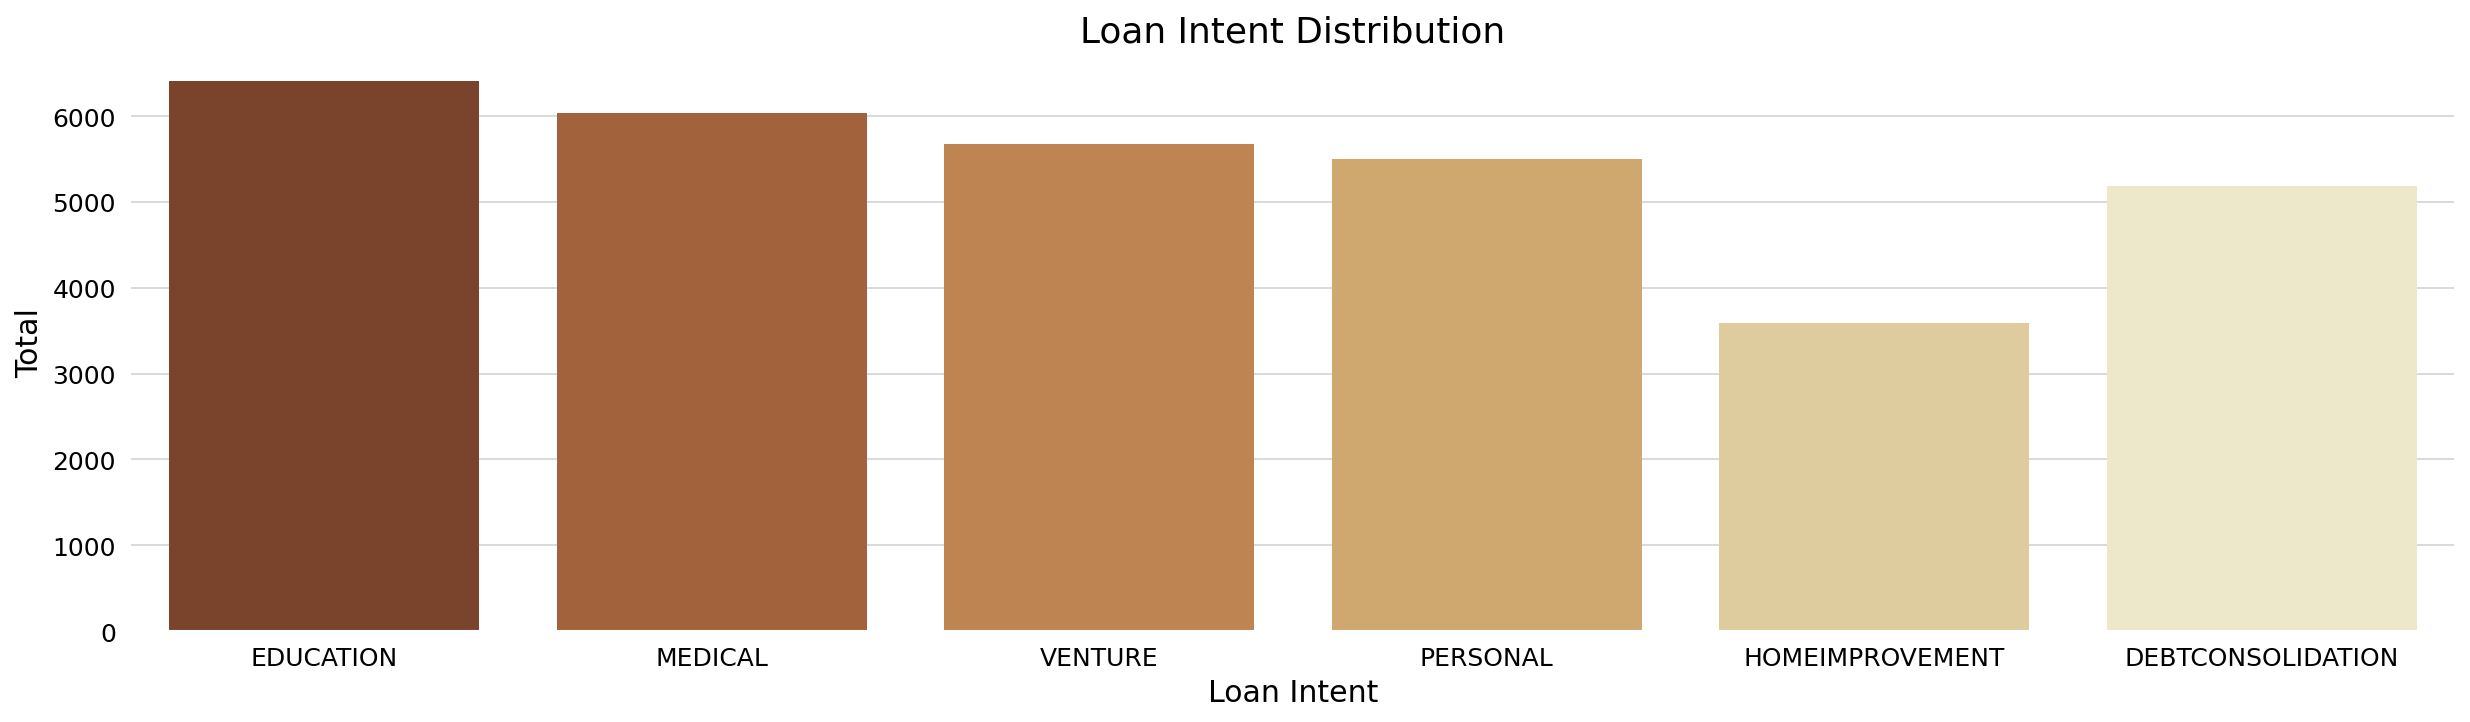

In [24]:
# Loan Intent countplot
sns.countplot(df, x='loan_intent', saturation=0.5)
# Settings
set_image('Loan Intent Distribution', 'Loan Intent', 'Total')

### 3.6. How is Home Ownership distributed through Loan Status?

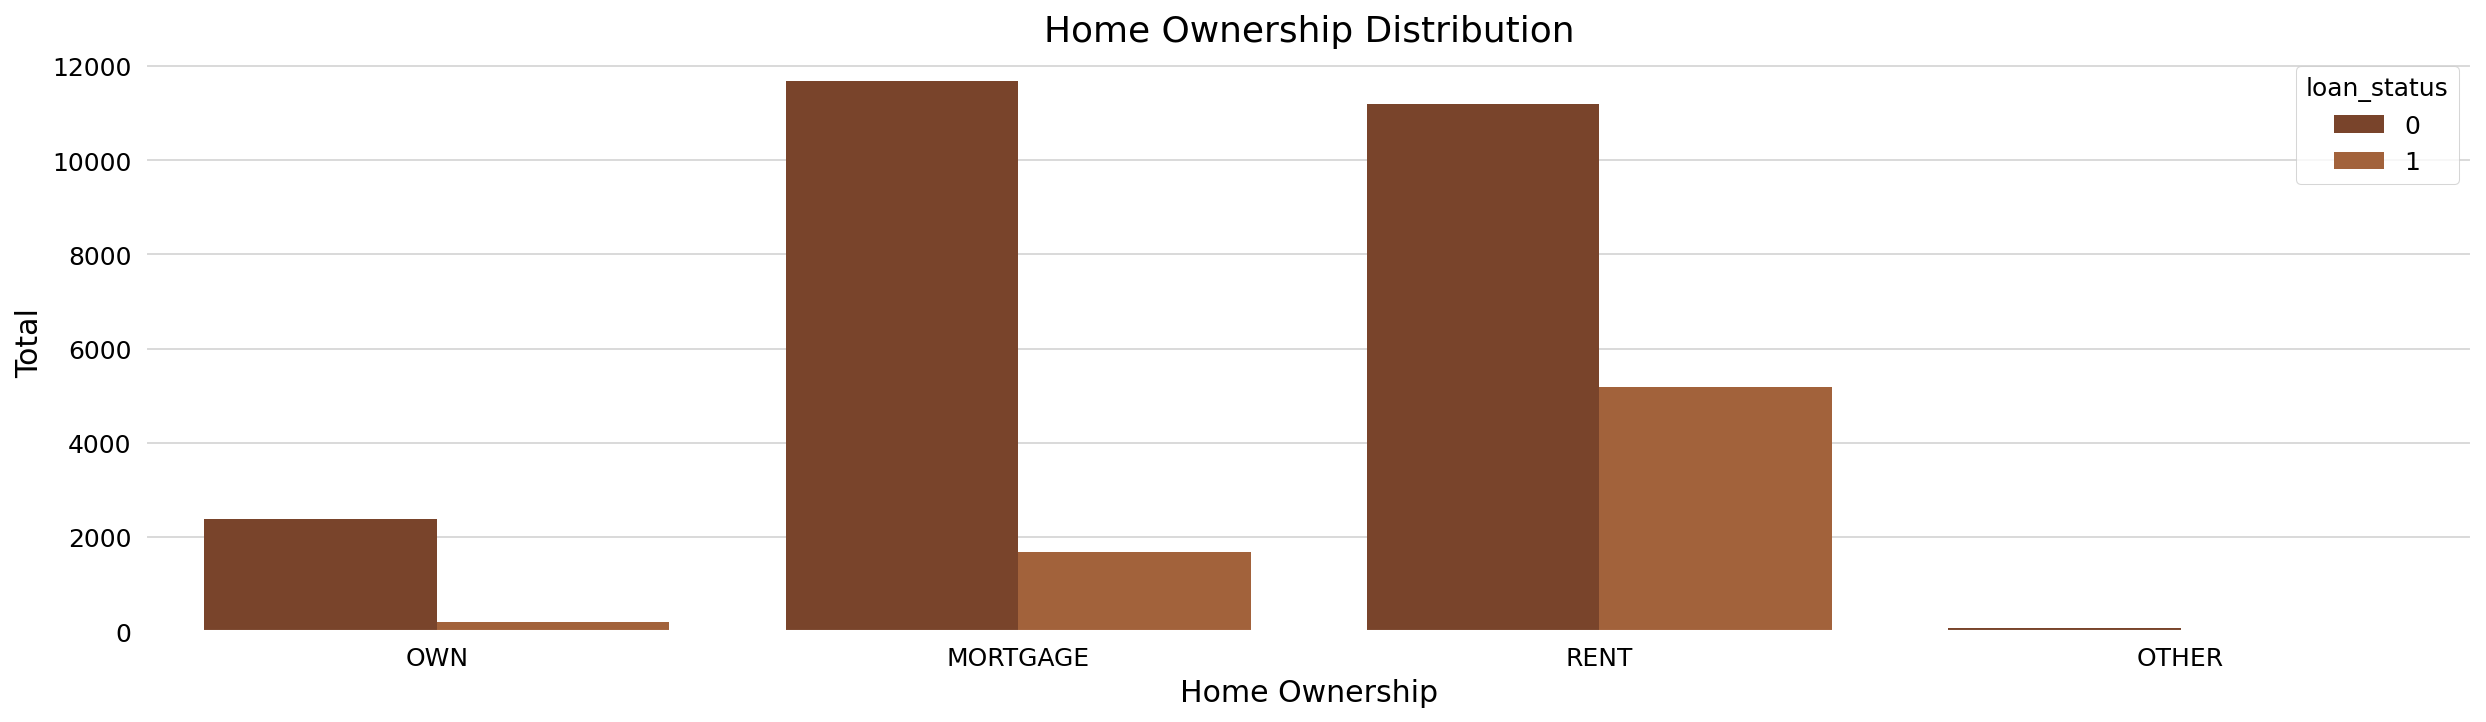

In [25]:
# Home Ownership countplot
sns.countplot(df, x='person_home_ownership', saturation=0.5, hue='loan_status')
# Settings
set_image('Home Ownership Distribution', 'Home Ownership', 'Total')

### 3.7. Distribution of Loan Status by Loan Grade

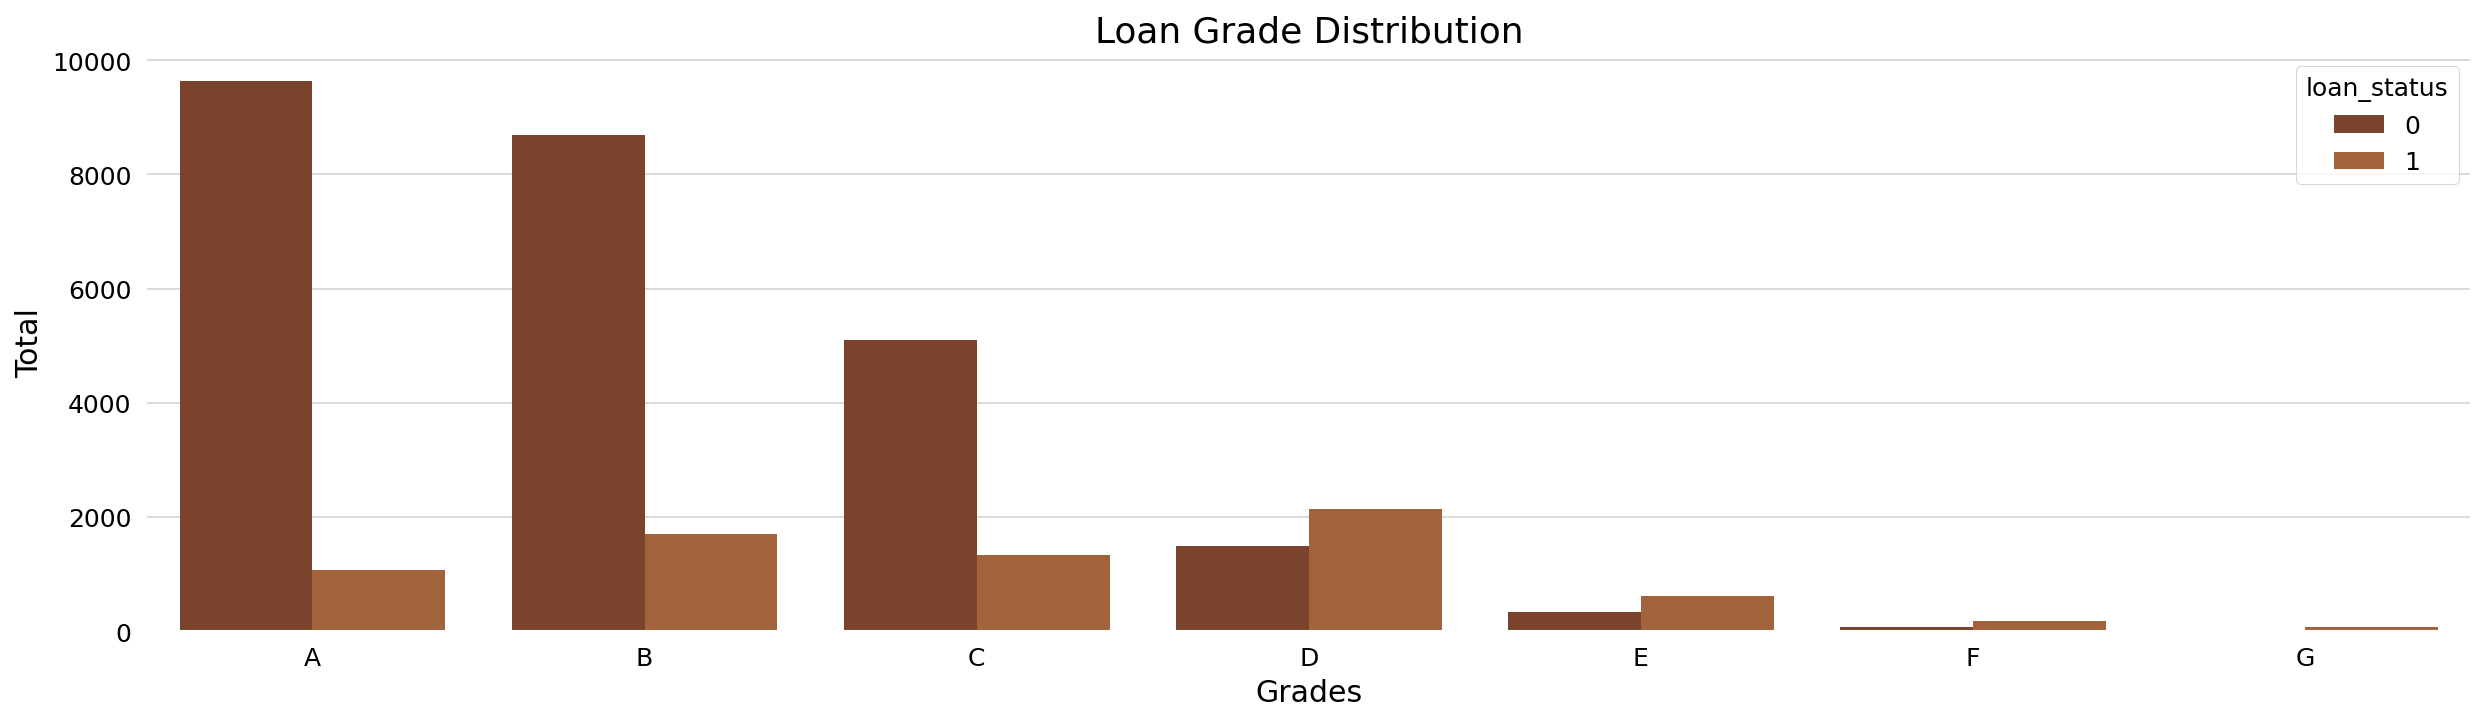

In [26]:
# Home Ownership countplot
sns.countplot(df, x='loan_grade', saturation=0.5, hue='loan_status', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
# Settings
set_image('Loan Grade Distribution', 'Grades', 'Total')

### 3.8. How is Loan Interest Rate related with Loan Amount?

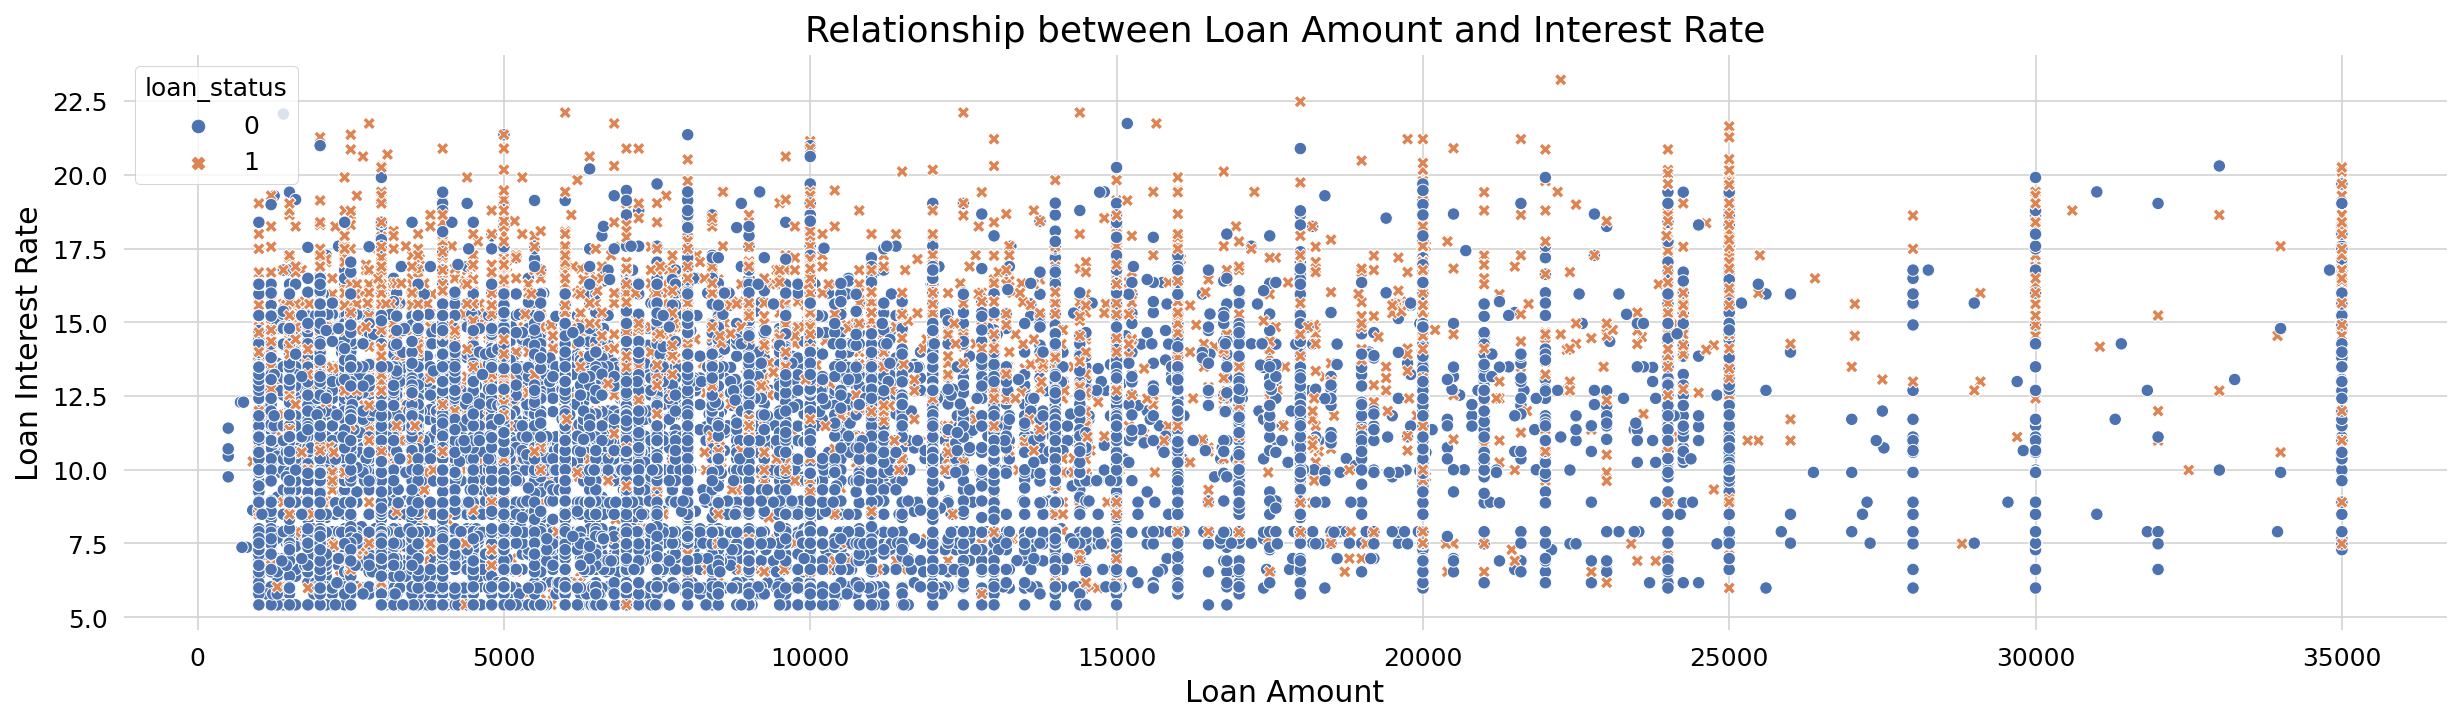

In [27]:
# Scatter plot between Loan Interest and Loan Amount
sns.scatterplot(data=df, x='loan_amnt', y='loan_int_rate', hue='loan_status', palette='deep', style='loan_status')
# Settings
set_image('Relationship between Loan Amount and Interest Rate', 'Loan Amount', 'Loan Interest Rate')

### 3.9. Distribution of Loan Interest Rate by Loan Status 

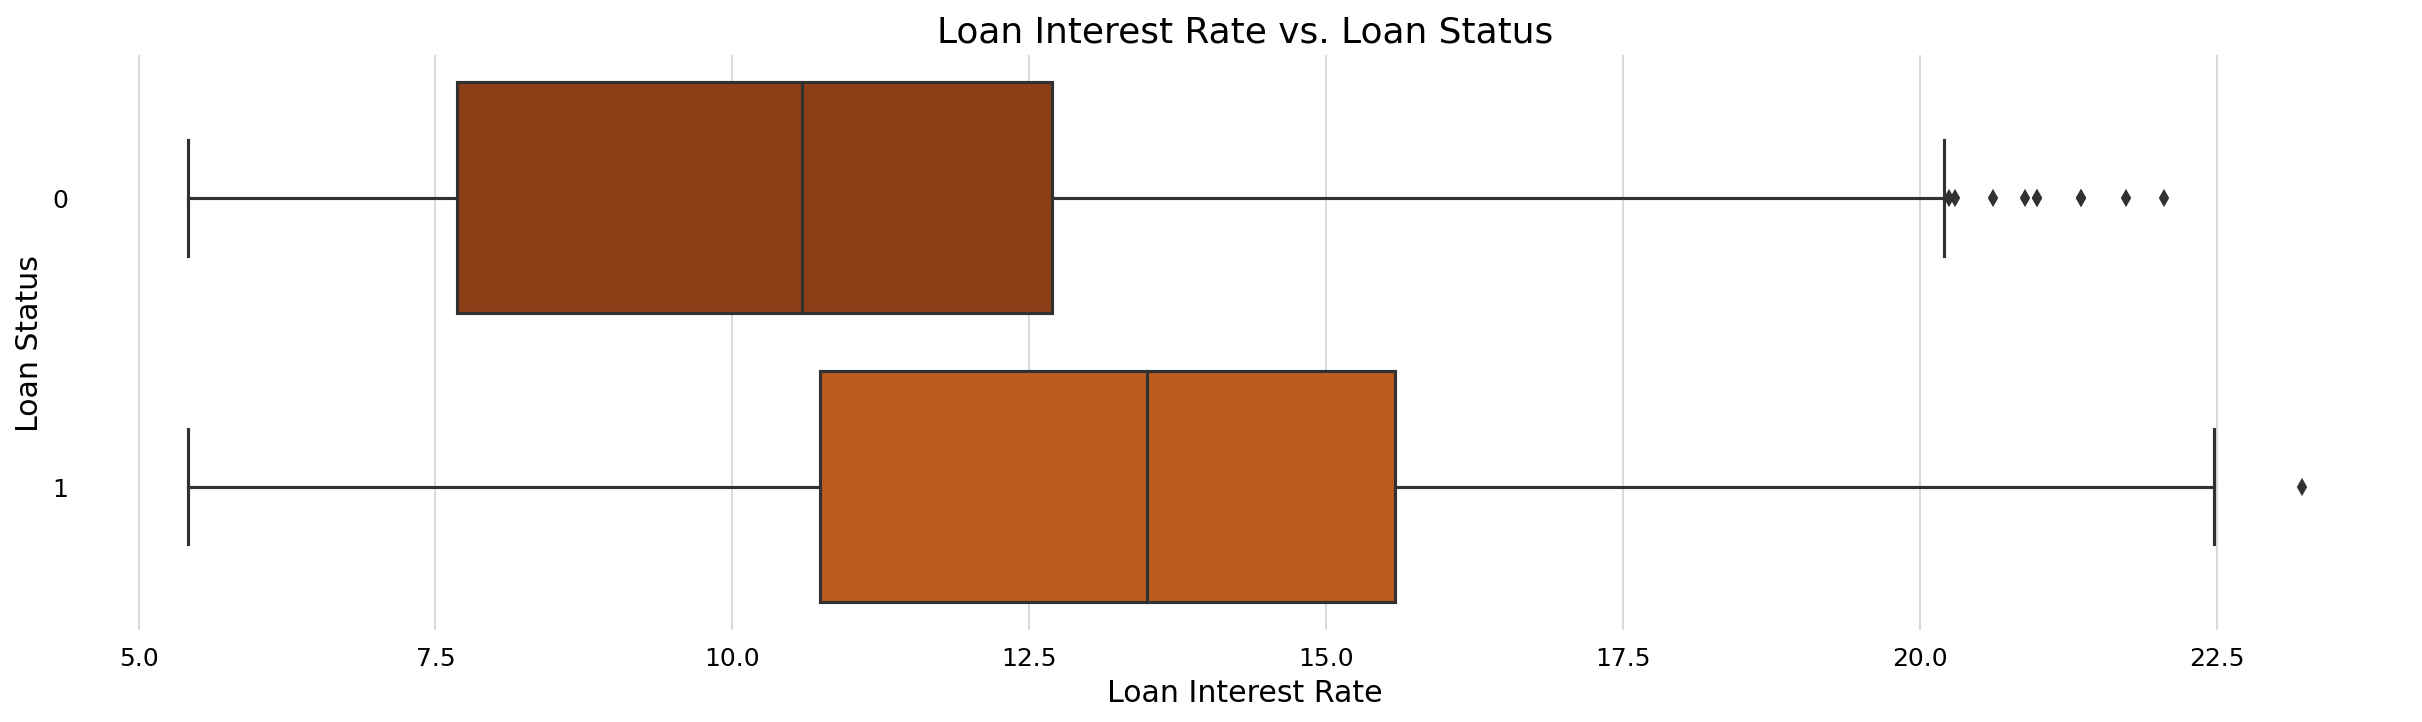

In [28]:
# Boxplot between Loan Interest and Loan Status
sns.boxplot(data=df, x = "loan_int_rate", y = "loan_status", orient='h')
# Settings
set_image('Loan Interest Rate vs. Loan Status', 'Loan Interest Rate', 'Loan Status')

### 3.10. Outliers Analysis

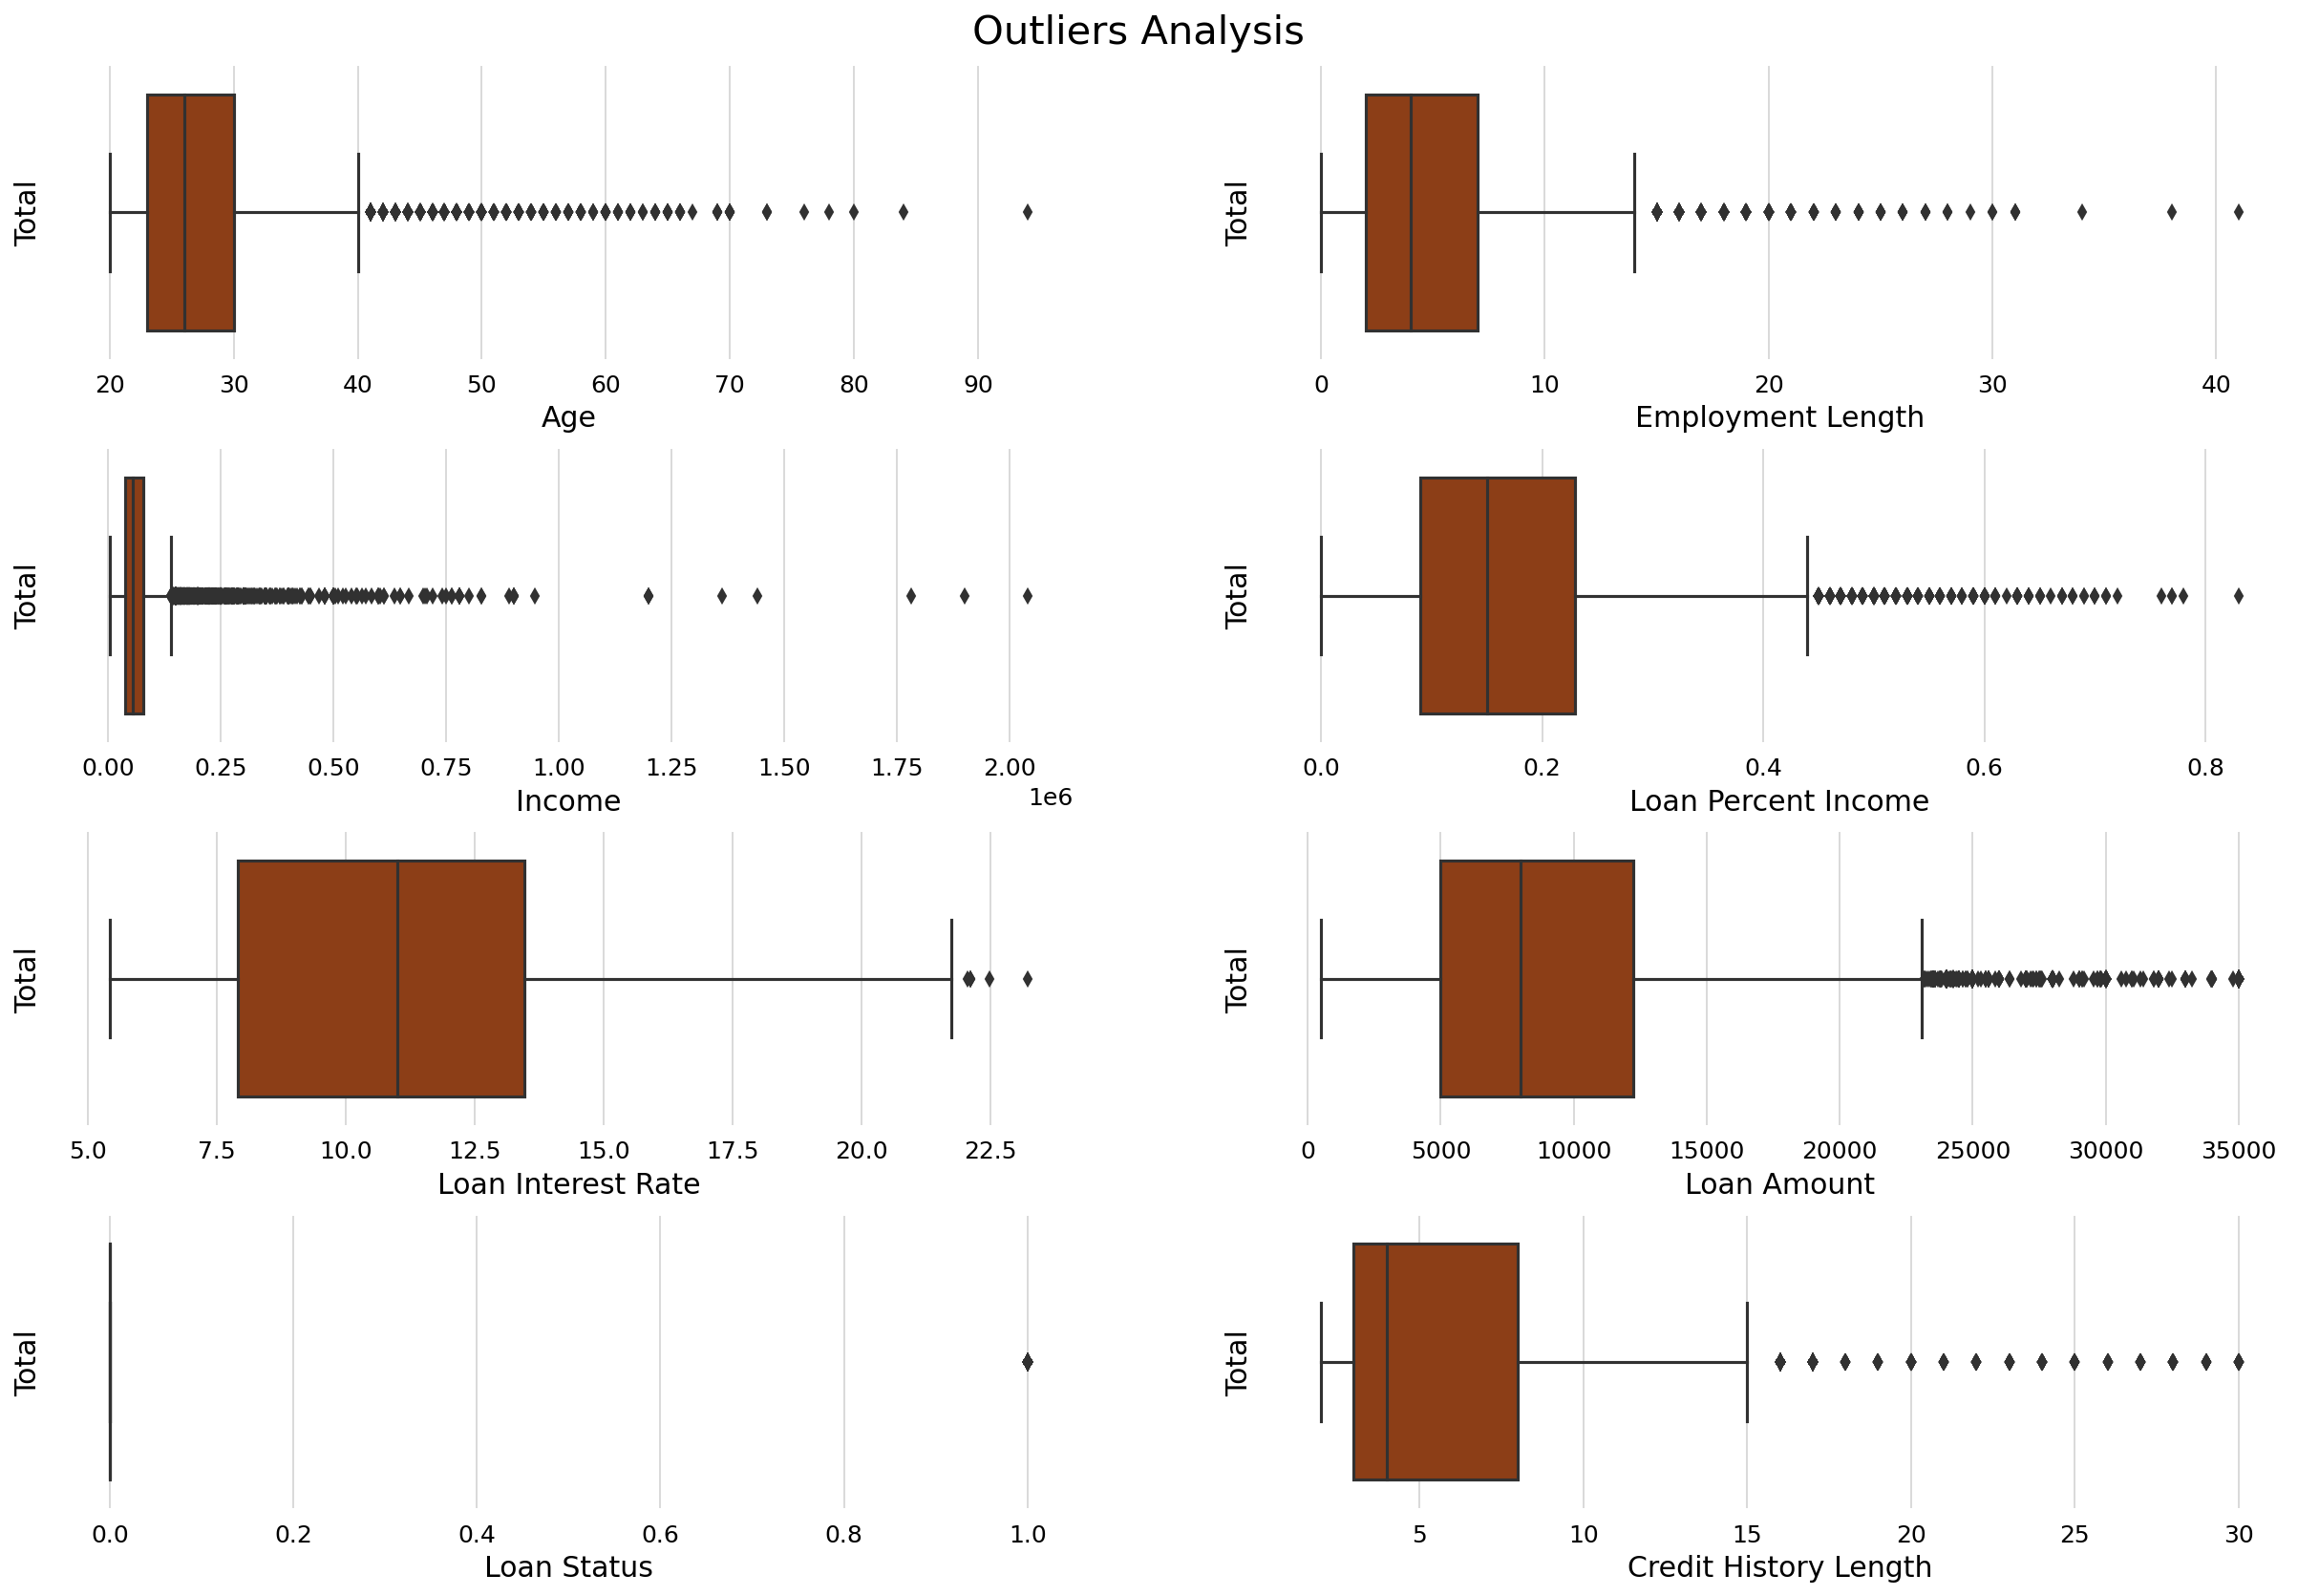

In [29]:
# Creating Figure
fig, axes  = plt.subplots(nrows=4, ncols=2, figsize=(20, 12))

# Subplots
plt.subplot(4, 2, 1)
sns.boxplot(data=df, x = 'person_age')
set_image(None, 'Age', 'Total')

plt.subplot(4, 2, 2)
sns.boxplot(data=df, x = 'person_emp_length')
set_image(None, 'Employment Length', 'Total')

plt.subplot(4, 2, 3)
sns.boxplot(data=df, x = 'person_income')
set_image(None, 'Income', 'Total')

plt.subplot(4, 2, 4)
sns.boxplot(data=df, x = 'loan_percent_income')
set_image(None, 'Loan Percent Income', 'Total')

plt.subplot(4, 2, 5)
sns.boxplot(data=df, x = 'loan_int_rate')
set_image(None, 'Loan Interest Rate', 'Total')

plt.subplot(4, 2, 6)
sns.boxplot(data=df, x = 'loan_amnt')
set_image(None, 'Loan Amount', 'Total')

plt.subplot(4, 2, 7)
sns.boxplot(data=df, x = 'loan_status')
set_image(None, 'Loan Status', 'Total')

plt.subplot(4, 2, 8)
sns.boxplot(data=df, x = 'cb_person_cred_hist_length')
set_image(None, 'Credit History Length', 'Total')

# Setting main plot title
fig.suptitle('Outliers Analysis', fontsize=20)

# Adjusting spacing
fig.subplots_adjust(top=0.95, hspace=0.3)

### 3.11. Analysis Conclusions

In the analysis, it is reasonable to conclude that borrower age has limited relevance in determining loan status.

Evidently, individual income does not significantly influence loan status, while the loan-to-income ratio does. Generally, borrowers who default tend to have a higher "loan percent income" than those who do not default. This suggests that individuals requesting a larger sum relative to their income are more likely to default, as expected.

Examining loan intent, it becomes clear that the most common purposes for loans are education, medical expenses, and ventures (projects or businesses). Conversely, making improvements to a borrower's home is the least common intent. The main reasons in loan intent do not vary substantially, unlike the data on home ownership.

Overall, the relationship between Loan Interest Rate and Loan Amount confirms that borrowers with higher interest rates are more likely to default, regardless of the loan amount.

## 4. Feature Engineering and Data Preparation

In [30]:
# Working with `df1` instead of `df`
df1 = df.copy()

### 4.1. Encoding

#### 4.1.1. Home Ownership

In [31]:
mapping = {'OTHER': 0, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3}

df1['person_home_ownership'] = df1['person_home_ownership'].map(mapping)

#### 4.1.2. Loan Grade

Through a quick analysis, we can see that G has the most Defaults proportionally to the other grades, while A and B do not have any. 
So we will start the count from A as 1 until the highest grade to G.

In [32]:
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

df1['loan_grade'] = df1['loan_grade'].map(mapping)

#### 4.1.3. Default on File

In [33]:
mapping = {
    'Y': 1, # Default
    'N': 0  # Not default
}

df1['cb_person_default_on_file'] = df1['cb_person_default_on_file'].map(mapping)

#### 4.1.4. Loan Intent

In [34]:
# Encoding
le = LabelEncoder()
# Applying label encoding
df1['loan_intent'] = le.fit_transform(df1['loan_intent'])

### 4.2. Correlation Heatmap

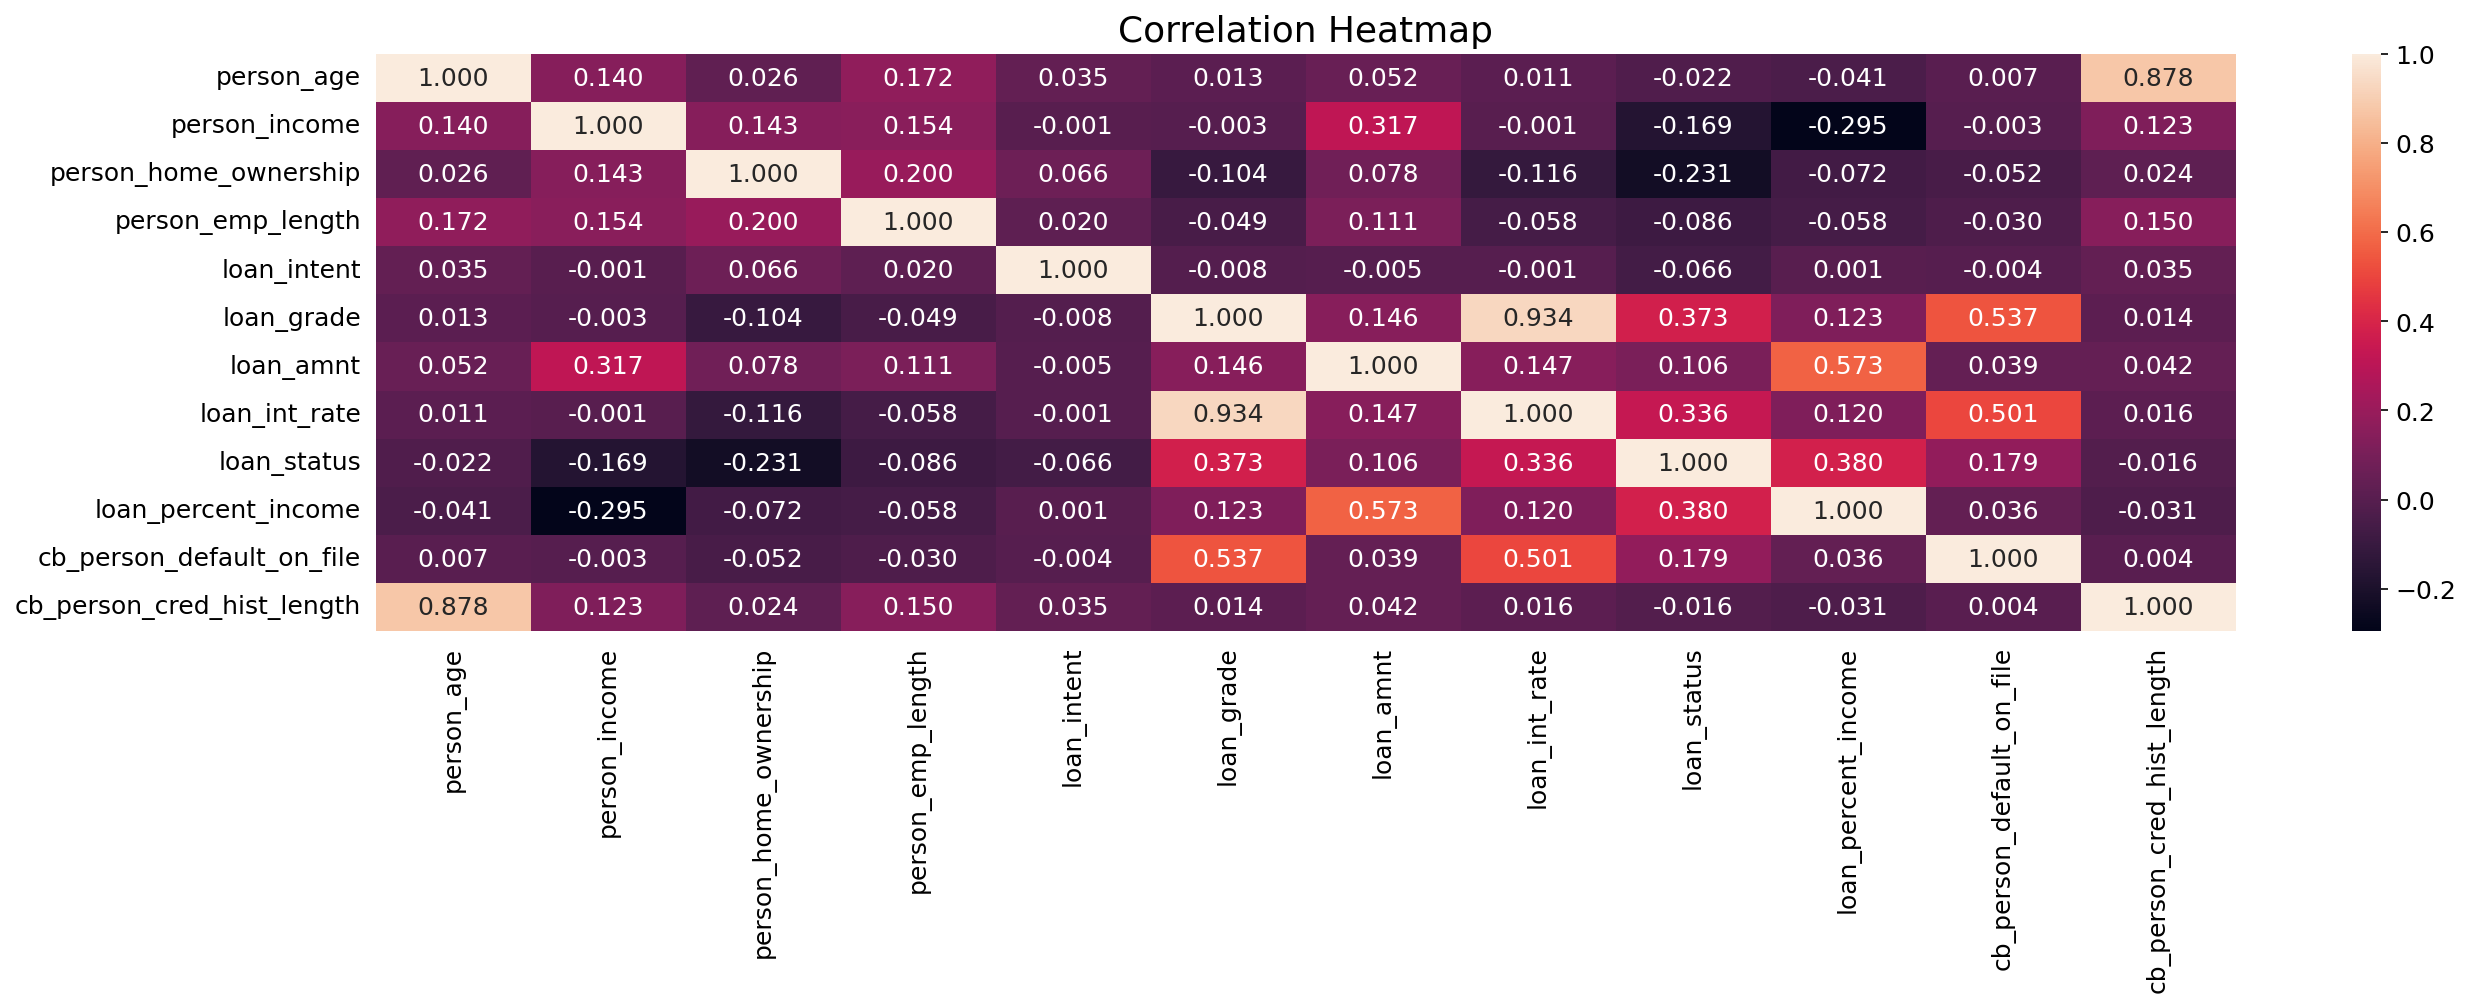

In [35]:
# Correlation Heatmap
sns.heatmap(df1.corr(), annot=True, fmt='.3f')
# Settings
set_image('Correlation Heatmap', None, None, 90)

### 4.3. Train Test Split

In [36]:
# Splitting the dataset

# Defining the features (X) and target variable (y)
X = df1.drop('loan_status', axis=1)
y = df1['loan_status']

# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.4. Handling NaN Values

In [37]:
df1.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3094
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

#### 4.4.1. KNN Imputation

In [38]:
# Creating a KNN imputer object with the desired number of neighbors (K)
knn_imputer = KNNImputer(n_neighbors=5)  # n_neighbors can be adjusted as needed

# Fit and transform for X_train
imputed_train = knn_imputer.fit_transform(X_train)

# Convert the imputed data back to a DataFrame
X_train = pd.DataFrame(imputed_train, columns=X_train.columns)

# Fit and transform for X_test
imputed_test = knn_imputer.fit_transform(X_test)

# Convert the imputed data back to a DataFrame
X_test = pd.DataFrame(imputed_test, columns=X_test.columns)

#### 4.4.2. Descriptive Statistics on Imputation

In [39]:
print(X_test[['loan_int_rate', 'person_emp_length']].describe().T)
print(X_train[['loan_int_rate', 'person_emp_length']].describe().T)

                     count   mean   std   min   25%    50%    75%    max
loan_int_rate     6482.000 10.985 3.137 5.420 8.070 10.990 13.220 21.360
person_emp_length 6482.000  4.821 3.997 0.000 2.000  4.000  7.000 28.000
                      count   mean   std   min   25%    50%    75%    max
loan_int_rate     25927.000 11.018 3.122 5.420 8.320 10.990 13.220 23.220
person_emp_length 25927.000  4.749 3.998 0.000 2.000  4.000  7.000 41.000


### 4.5. Transformations

In [40]:
# Create a StandardScaler instance
standard = StandardScaler()

# Fit the scaler on training data
X_train[['loan_int_rate', 'person_emp_length']] = standard.fit_transform(
    X_train[['loan_int_rate', 'person_emp_length']].values)

# Fit the scaler on test data
X_test[['loan_int_rate', 'person_emp_length']] = standard.fit_transform(
    X_test[['loan_int_rate', 'person_emp_length']].values)

In [41]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,25927.000,27.740,6.198,20.000,23.000,26.000,30.000,94.000
person_income,25927.000,65740.374,52044.114,4000.000,38400.000,55000.000,79000.000,2039784.000
person_home_ownership,25927.000,1.567,0.640,0.000,1.000,1.000,2.000,3.000
person_emp_length,25927.000,0.000,1.000,-1.188,-0.688,-0.187,0.563,9.068
loan_intent,25927.000,2.535,1.733,0.000,1.000,3.000,4.000,5.000
loan_grade,25927.000,2.221,1.167,1.000,1.000,2.000,3.000,7.000
loan_amnt,25927.000,9595.120,6326.156,500.000,5000.000,8000.000,12000.000,35000.000
loan_int_rate,25927.000,-0.000,1.000,-1.793,-0.864,-0.009,0.705,3.908
loan_percent_income,25927.000,0.171,0.107,0.000,0.090,0.150,0.230,0.830
cb_person_default_on_file,25927.000,0.176,0.381,0.000,0.000,0.000,0.000,1.000


In [42]:
# Create a RobustScaler instance
scaler = RobustScaler()

# Fit the scaler on training data
X_train[['person_income', 'loan_amnt']] = scaler.fit_transform(
    X_train[['person_income', 'loan_amnt']].values)

# Fit the scaler on test data
X_test[['person_income', 'loan_amnt']] = scaler.fit_transform(
    X_test[['person_income', 'loan_amnt']].values)

In [43]:
# Dropping features
X_train = X_train.drop(['person_age', 'cb_person_cred_hist_length'], axis=1)
X_test = X_test.drop(['person_age', 'cb_person_cred_hist_length'], axis=1)

## 5. Machine Learning

### 5.1. Models

In [44]:
# Creating a RandomForestClassifier Model
randomf_model = RandomForestClassifier(n_estimators=500, max_depth=7, random_state=42)

# Fit the classifier to the training data
randomf_model.fit(X_train, y_train)

# Make predictions on the test data
rf_y_pred = randomf_model.predict(X_test)

In [45]:
# Evaluate the model
accuracy    = accuracy_score(y_test, rf_y_pred)
confusion   = confusion_matrix(y_test, rf_y_pred)
report      = classification_report(y_test, rf_y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)


Accuracy: 0.9242517741437828
Confusion Matrix:
 [[5025   35]
 [ 456  966]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      5060
           1       0.97      0.68      0.80      1422

    accuracy                           0.92      6482
   macro avg       0.94      0.84      0.88      6482
weighted avg       0.93      0.92      0.92      6482



In [46]:
# Creating a LGBMClassifier Model
lgbm_model = LGBMClassifier(n_estimators=500, max_depth=-1, learning_rate=0.1, num_leaves=64, random_state=42)

# Fit the classifier to the training data
lgbm_model.fit(X_train, y_train)

# Make predictions on the test data
lgbm_y_pred = lgbm_model.predict(X_test)

In [47]:
# Evaluate the model
accuracy    = accuracy_score(y_test, lgbm_y_pred)
confusion   = confusion_matrix(y_test, lgbm_y_pred)
report      = classification_report(y_test, lgbm_y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)

Accuracy: 0.9321197161369947
Confusion Matrix:
 [[4982   78]
 [ 362 1060]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      5060
           1       0.93      0.75      0.83      1422

    accuracy                           0.93      6482
   macro avg       0.93      0.87      0.89      6482
weighted avg       0.93      0.93      0.93      6482



In [48]:
# Creating CatBoostClassifier Model
catboost_model = CatBoostClassifier(
    iterations=500,  # Number of boosting iterations
    learning_rate=0.1,  # Step size for updates
    depth=6,  # Depth of the trees
    l2_leaf_reg=3,  # L2 regularization parameter
    border_count=254,  # Number of splits for numerical features
    custom_metric=['AUC'],  # Use AUC as a custom metric
    od_type='IncToDec',  # Type of early stopping
    od_wait=30,  # Number of iterations to wait for early stopping
    random_seed=42  # Set a random seed for reproducibility
)

# Fit the classifier to the training data
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

# Make predictions on the test data
cb_y_pred = catboost_model.predict(X_test)

0:	learn: 0.5874812	test: 0.5871693	best: 0.5871693 (0)	total: 200ms	remaining: 1m 39s
100:	learn: 0.2003919	test: 0.2067717	best: 0.2067717 (100)	total: 1.44s	remaining: 5.7s
200:	learn: 0.1786505	test: 0.2018344	best: 0.2018344 (200)	total: 3.04s	remaining: 4.53s
300:	learn: 0.1648697	test: 0.1997597	best: 0.1997597 (300)	total: 4.31s	remaining: 2.85s
400:	learn: 0.1540683	test: 0.1990980	best: 0.1990803 (372)	total: 5.64s	remaining: 1.39s
499:	learn: 0.1449958	test: 0.1992726	best: 0.1989161 (440)	total: 6.91s	remaining: 0us

bestTest = 0.1989160556
bestIteration = 440

Shrink model to first 441 iterations.


In [49]:
# Evaluate the model
accuracy    = accuracy_score(y_test, cb_y_pred)
confusion   = confusion_matrix(y_test, cb_y_pred)
report      = classification_report(y_test, cb_y_pred)
roc_auc     = roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)
print("ROC AUC:\n", roc_auc)

Accuracy: 0.9370564640543042
Confusion Matrix:
 [[5027   33]
 [ 375 1047]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5060
           1       0.97      0.74      0.84      1422

    accuracy                           0.94      6482
   macro avg       0.95      0.86      0.90      6482
weighted avg       0.94      0.94      0.93      6482

ROC AUC:
 0.9351541001651072


### 5.2. Output

The CatBoostClassifier model presents the best metrics in terms of Accuracy, Confusion Matrix and Classification Report among all models tested. Therefore, the Business Results will be based on this model results.

In [50]:
predictions = catboost_model.predict_proba(X_test)
predictions

array([[0.94174934, 0.05825066],
       [0.96092783, 0.03907217],
       [0.98923056, 0.01076944],
       ...,
       [0.84223732, 0.15776268],
       [0.99216112, 0.00783888],
       [0.8234509 , 0.1765491 ]])

In [51]:
# Creating a dataframe with probabilities
df_prediction_prob = pd.DataFrame(predictions, columns = ['prob_0', 'prob_1'])

# Adding the predicted target
df_prediction_target = pd.DataFrame(catboost_model.predict(X_test), columns = ['pred_target'])

# Adding the actual outcome
df_test_dataset = y_test.to_frame(name='actual_outcome').reset_index(drop=True)

# Concatenating
output = pd.concat([df_test_dataset, df_prediction_prob, df_prediction_target], axis = 1)

# Display
output

,actual_outcome,prob_0,prob_1,pred_target
0,0,0.942,0.058,0
1,0,0.961,0.039,0
2,0,0.989,0.011,0
3,0,0.993,0.007,0
4,0,0.891,0.109,0
...,...,...,...,...
6477,1,0.079,0.921,1
6478,0,0.939,0.061,0
6479,0,0.842,0.158,0
6480,0,0.992,0.008,0


In [52]:
# Sorting by probability of non-default
output.sort_values(by='prob_0', ascending = False, inplace = True)

# Crating deciles
output['decile'] = pd.qcut(output['prob_0'], q=10, labels=False)

# Deciles in inversed order
output['decile'] = (9 - output['decile']) + 1

# Display 
output

,actual_outcome,prob_0,prob_1,pred_target,decile
2721,0,1.000,0.000,0,1
1395,0,1.000,0.000,0,1
2908,0,1.000,0.000,0,1
2425,0,1.000,0.000,0,1
2079,0,1.000,0.000,0,1
...,...,...,...,...,...
4875,1,0.000,1.000,1,10
1376,1,0.000,1.000,1,10
2689,1,0.000,1.000,1,10
4209,1,0.000,1.000,1,10


## 6. Business Performance

### 6.1. Calculating Performance Metrics

In [53]:
# Empty dictionary
bp = {
    'decile':[],
    'count_of_decile': [],
    'sum_of_actual_outcome': [],
    'min_prob_good': [],
    'good': []
}

# Loop through each decile 
for i in range(1,11):
    aux = output.loc[output['decile'] == i]
    
    count_of_decile = len(aux)
    sum_of_actual_outcome = aux['actual_outcome'].sum()
    min_prob_good = aux['prob_0'].min()
    good = count_of_decile - sum_of_actual_outcome

    bp['decile'].append(i)
    bp['count_of_decile'].append(count_of_decile)
    bp['sum_of_actual_outcome'].append(sum_of_actual_outcome)
    bp['min_prob_good'].append(min_prob_good)
    bp['good'].append(good)

# From dictionary to dataframe
bp = pd.DataFrame.from_dict(bp)

# Adding cumulative values
for row in bp.index:
    bp.loc[row, 'cumm_good'] = bp.head(row+1)['good'].sum()
    bp.loc[row, 'cumm_bad'] = bp.head(row+1)['sum_of_actual_outcome'].sum()

# Adding percentages
bp['cumm_good_perc'] = bp['cumm_good']/bp['good'].sum()
bp['cumm_bad_perc'] = bp['cumm_bad']/bp['sum_of_actual_outcome'].sum()
bp['cumm_bad_avoided_perc'] = 1 - bp['cumm_bad_perc']

# New index
bp.set_index('decile', inplace=True)

# Display
bp


,count_of_decile,sum_of_actual_outcome,min_prob_good,good,cumm_good,cumm_bad,cumm_good_perc,cumm_bad_perc,cumm_bad_avoided_perc
decile,,,,,,,,,
1,649,0,0.996,649,649.000,0.000,0.128,0.000,1.000
2,648,4,0.983,644,1293.000,4.000,0.256,0.003,0.997
3,648,15,0.968,633,1926.000,19.000,0.381,0.013,0.987
4,648,32,0.952,616,2542.000,51.000,0.502,0.036,0.964
5,648,38,0.933,610,3152.000,89.000,0.623,0.063,0.937
6,648,58,0.905,590,3742.000,147.000,0.740,0.103,0.897
7,648,78,0.860,570,4312.000,225.000,0.852,0.158,0.842
8,648,101,0.722,547,4859.000,326.000,0.960,0.229,0.771
9,648,447,0.015,201,5060.000,773.000,1.000,0.544,0.456


### 6.2. Results Table

In [54]:
# Copy
business_results = bp.copy()

# Changing data types
business_results['cumm_good']               = business_results['cumm_good'].astype(int)
business_results['cumm_bad']                = business_results['cumm_bad'].astype(int)

# Formatting
business_results['min_prob_good']           = (np.round(business_results['min_prob_good'] * 100, 1)).astype(str) + '%'
business_results['cumm_good_perc']          = (np.round(business_results['cumm_good_perc'] * 100, 1)).astype(str) + '%'
business_results['cumm_bad_perc']           = (np.round(business_results['cumm_bad_perc'] * 100, 1)).astype(str) + '%'
business_results['cumm_bad_avoided_perc']   = (np.round(business_results['cumm_bad_avoided_perc'] * 100, 1)).astype(str) + '%'

# Display
business_results


,count_of_decile,sum_of_actual_outcome,min_prob_good,good,cumm_good,cumm_bad,cumm_good_perc,cumm_bad_perc,cumm_bad_avoided_perc
decile,,,,,,,,,
1,649,0,99.6%,649,649,0,12.8%,0.0%,100.0%
2,648,4,98.3%,644,1293,4,25.6%,0.3%,99.7%
3,648,15,96.8%,633,1926,19,38.1%,1.3%,98.7%
4,648,32,95.2%,616,2542,51,50.2%,3.6%,96.4%
5,648,38,93.3%,610,3152,89,62.3%,6.3%,93.7%
6,648,58,90.5%,590,3742,147,74.0%,10.3%,89.7%
7,648,78,86.0%,570,4312,225,85.2%,15.8%,84.2%
8,648,101,72.2%,547,4859,326,96.0%,22.9%,77.1%
9,648,447,1.5%,201,5060,773,100.0%,54.4%,45.6%


#### 6.2.1. Reading the Results Table

In the first deciles we find our top-performing customers. For businesses seeking a highly conservative loan approval strategy, these top deciles offer an ideal choice. They exhibit an impressive minimum non-default probability, for the example of decile 5 which presents a cutoff probability of 93.3%, with only 89 out of 3,241 borrowers expected to default. By selecting the top half of deciles, a business can effectively avoid 93.7% of high-risk customers.

However, it's essential for a bank to align its strategy with the business's objectives. In other words, the bank must determine the desired level of exposure to risky customers. As we move down the decile sets, businesses can access a larger pool of good customers, but this expansion comes at the trade-off of increasing exposure to higher-risk borrowers. Therefore, the selection of deciles is a strategic decision that must be finely tuned to strike the right balance between growing the customer base and managing risk effectively.

### 6.3. Profit to Business

Taking the profit assumptions into account, we have that every good customer returns 100 dollars as profit and every bad customer costs 500 dollars. We calculate the profit to the bank.

In [55]:
import locale

locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Calculating the profit to business
business_results['profit_to_business'] = business_results['cumm_good'] * 100 - business_results['cumm_bad'] * 500

# Apply locale formatting to the column
business_results['profit_to_business'] = business_results['profit_to_business'].apply(lambda x: locale.format_string("%d", x, grouping=True))

# Formatting the column as currency
business_results['profit_to_business'] = '$' + ((business_results['profit_to_business']).astype(str))

# Display
business_results

,count_of_decile,sum_of_actual_outcome,min_prob_good,good,cumm_good,cumm_bad,cumm_good_perc,cumm_bad_perc,cumm_bad_avoided_perc,profit_to_business
decile,,,,,,,,,,
1,649,0,99.6%,649,649,0,12.8%,0.0%,100.0%,"$64,900"
2,648,4,98.3%,644,1293,4,25.6%,0.3%,99.7%,"$127,300"
3,648,15,96.8%,633,1926,19,38.1%,1.3%,98.7%,"$183,100"
4,648,32,95.2%,616,2542,51,50.2%,3.6%,96.4%,"$228,700"
5,648,38,93.3%,610,3152,89,62.3%,6.3%,93.7%,"$270,700"
6,648,58,90.5%,590,3742,147,74.0%,10.3%,89.7%,"$300,700"
7,648,78,86.0%,570,4312,225,85.2%,15.8%,84.2%,"$318,700"
8,648,101,72.2%,547,4859,326,96.0%,22.9%,77.1%,"$322,900"
9,648,447,1.5%,201,5060,773,100.0%,54.4%,45.6%,"$119,500"


As evident from the data, the peak of profitability is achieved in the eighth decile, delivering a profit of $322,900. Nevertheless, banks may opt to explore opportunities in the adjacent deciles, even while some potential profits may be sacrificed. 

Dividing the data into centiles, we would observe a more balanced distribution. We could advance more through the centiles, increasing the exposure to higher-risk customers and yet maintaining a balance between growing the customer base and managing risk effectively.

This strategic decision allows banks to not only maximize their market share but also broadens their customer base,  with a consideration of the trade-off in potential profitability.

### 6.4. ROC Curve

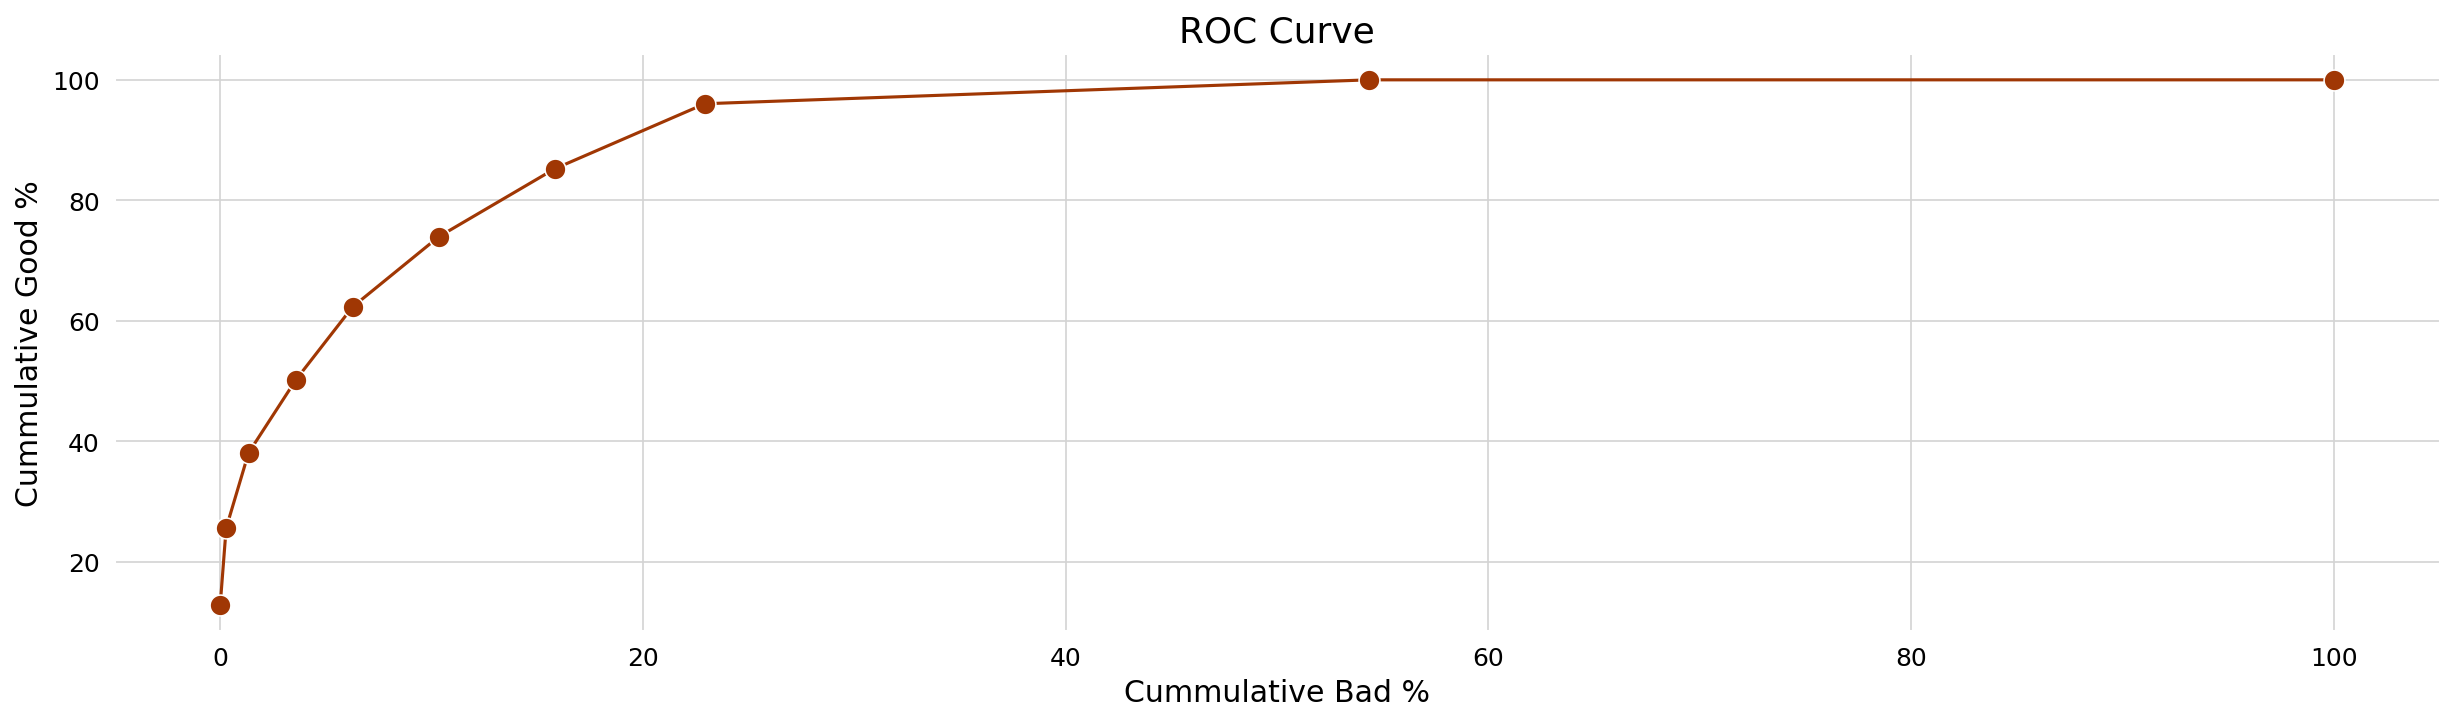

In [56]:
# Creating empty dataframe
aux = pd.DataFrame()

# Formatting columns
aux['cumm_bad_perc']    = np.round(bp['cumm_bad_perc']*100, 2)
aux['cumm_good_perc']   = np.round(bp['cumm_good_perc']*100, 2)

# Creating Plot
sns.lineplot(data=aux, x='cumm_bad_perc', y='cumm_good_perc', marker='o', markersize=10)

# Settings
plt.grid(True)
set_image('ROC Curve', 'Cummulative Bad %', 'Cummulative Good %')

## 7. Conclusion

**Improving Profitability for a Conservative Bank Through Informed Decision-Making**

This Credit Score Project aimed to build an in-house risk model for the bank to maximize profits. Our central aim is to optimize profitability while adhering to a cautious approach. Each good customer is expected to bring in a profit of 100 dollars, while the cost of a bad customer is a significant 500 dollars. 

Taking into account that the bank's business strategy is to take as little risk as possible while making a profit, the first five deciles are the ideal choice for conservative loan approval strategies. From the sixth decile to the last, the profit would start to decrease as the bank expands its market presence. By selecting these top half deciles enables businesses to avoid 93.7% of risky customers. 

The eighth decile emerges as the peak of profitability, but the higher exposure to higher-risk customers does not compensate the improvement in profits for this conservative bank institution.